<a href="https://colab.research.google.com/github/JayeMineM/4PtsPerspect_ARosebrock/blob/main/review2025Apr16_19_UoB_FDP_pyFile_workingOn_bbFACEbin_TurningCNNimgClass_intoObjDetect_KerasTFlowOpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV
by Adrian Rosebrock on June 22, 2020

https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

Click here to download the source code to this post

In this tutorial, you will learn how to take any pre-trained deep learning image classifier and turn it into an object detector using Keras, TensorFlow, and OpenCV.

Today, we’re starting a four-part series on deep learning and object detection:

* Part 1: Turning any deep learning image classifier into an object detector with Keras and TensorFlow (today’s post)
*Part 2: OpenCV Selective Search for Object Detection
*Part 3: Region proposal for object detection with OpenCV, Keras, and TensorFlow
*Part 4: R-CNN object detection with Keras and TensorFlow

The goal of this series of posts is to obtain a deeper understanding of how deep learning-based object detectors work, and more specifically:

1. How traditional computer vision object detection algorithms can be combined with deep learning
2. What the motivations behind end-to-end trainable object detectors and the challenges associated with them are
3. **And most importantly**, how the seminal Faster R-CNN architecture came to be (we’ll be building a variant of the R-CNN architecture throughout this series)

Today, we’ll be starting with the fundamentals of object detection, including how to take a pre-trained image classifier and utilize **image pyramids, sliding windows, and non-maxima suppression** to build a basic object detector (think **HOG**(Histogram of Oriented Gradients) + Linear **SVM**(Support Vector Machine)-inspired).

In the first part of this tutorial, we’ll discuss the key differences between image classification and object detection tasks.

I’ll then show you how you can **take ANY Convolutional Neural Network trained for image classification and then turn it into an object detector,** all in ~200 lines of code.

From there, we’ll implement the code necessary to take an image classifier and turn it into an object detector using Keras, TensorFlow, and OpenCV.

Finally, we’ll review the results of our work, noting some of the problems and limitations with our implementation, including how we can improve this method.

**Image classification vs. object detection**
![](https://www.pyimagesearch.com/wp-content/uploads/2018/05/gentle_guide_obj_det_cls_vs_det.jpg)

**Figure 1:** Left: Image classification. Right: Object detection. In this blog post, we will learn how to turn any deep learning image classifier CNN into an object detector with Keras, TensorFlow, and OpenCV.


[...] --object detection does require a specialized network architecture.

Anyone who has read papers on Faster R-CNN, Single Shot Detectors (SSDs), YOLO, RetinaNet, etc. knows that object detection networks are more complex, more involved, and take multiple orders of magnitude and more effort to implement compared to traditional image classification.

That said, there is a hack we can leverage to turn our CNN image classifier into an object detector — and the secret sauce lies in traditional computer vision algorithms.

Back before deep learning-based object detectors, the state-of-the-art was to use HOG + Linear SVM to detect objects in an image.

We’ll be borrowing elements from [HOG + Linear SVM](https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/) to convert any deep neural network image classifier into an object detector.

###**The first key ingredient from HOG + Linear SVM is to use _image pyramids_.**

An “image pyramid” is a **multi-scale representation** of an image:
![](https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_pyramid_example_2.png)

**Figure 2:** Image pyramids allow us to produce images at different scales. When turning an image classifier into an object detector, it is important to classify windows at multiple scales. We will learn how to write an image pyramid Python generator and put it to work in our Keras, TensorFlow, and OpenCV script.

And at each subsequent layer, **the image is resized (subsampled)** and optionally smoothed (usually via Gaussian blurring).

**The image is progressively subsampled until some stopping criterion is met**, which is normally when a minimum size has been reached and no further subsampling needs to take place.

###**The second key ingredient we need is sliding windows:**
![](https://www.pyimagesearch.com/wp-content/uploads/2014/10/sliding_window_example.gif)
**Figure 3:** We will classify regions of our multi-scale image representations. These regions are generated by means of sliding windows. `The combination of image pyramids and sliding windows allow us to turn any image classifier into an object detector` using Keras, TensorFlow, and OpenCV.

As the name suggests, a sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image. (As Figure 3 demonstrates, our sliding window could be used to detect the face in the input image).

At each stop of the window we would:
```
1. Extract the ROI
2. Pass it through our image classifier (ex., Linear SVM, CNN, etc.)
3. Obtain the output predictions
```
**Combined with image pyramids, sliding windows allow us to localize objects at different locations and multiple scales of the input image:




![Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV - PyImageSearch](<p><a href="https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/?wvideo=3g5zxb6jec"><img src="https://embed-fastly.wistia.com/deliveries/240c4fa1e17cb3d6b5f9e9b98b2d160485fa69a4.jpg?image_play_button_size=2x&amp;image_crop_resized=960x421&amp;image_play_button=1&amp;image_play_button_color=1e71e7e0" width="400" height="175" style="width: 400px; height: 175px;"></a></p><p><a href="https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/?wvideo=3g5zxb6jec"></a></p>)

###**Combining traditional computer vision with deep learning to build an object detector**
![](https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_steps.png)
**Figure 6:** The steps to turn a deep learning classifier into an object detector using Python and libraries such as TensorFlow, Keras, and OpenCV.
**BlockDiagram**

In order to take any Convolutional Neural Network trained for image classification and instead utilize it for object detection, we’re going to utilize the three key ingredients for traditional computer vision:

1. **Image pyramids:** Localize objects at different scales/sizes.
2. **Sliding windows:** Detect exactly where in the image a given object is.
3. **Non-maxima suppression:** Collapse weak, overlapping bounding boxes.

              -----------------------------------------
**DJSc_Appendix:**
* HOG
The Histogram of Oriented Gradients (HOG) algorithm is a feature descriptor used in computer vision for object detection and image processing. It works by capturing the structure and texture of an image by focusing on the gradients, which represent changes in intensity. HOG analyzes the orientation and magnitude of these gradients within small, localized regions of an image, then uses these gradients to create a feature vector that represents the image's overall shape and structure.

A histogram of oriented gradient (HOG) is a common descriptor used in computer vision and image processing. It involves decomposing images into a dense array of cells and calculating a histogram of gradients for each cell, which is then normalized by the overlapping of local cell contrast.


##**Configuring your development environment**

Install TensorFlow 2.0

####**JaySTRATEGY**

In [1]:
#JayADD...
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4546115950108857259
 xla_global_id: -1]

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [4]:
#pip install -U --pre tensorflow=='2.4'

##**Project structure**
Once you extract the .zip from the “Downloads” section of this blog post, your directory will be organized as follows:
```
.
├── images
│   ├── hummingbird.jpg
│   ├── lawn_mower.jpg
│   └── stingray.jpg
├── pyimagesearch
│   ├── __init__.py
│   └── detection_helpers.py
└── detect_with_classifier.py
```

Today’s pyimagesearch module contains a Python file — detection_helpers.py — consisting of two helper functions:

* **image_pyramid:** assists in generating copies of our image at different scales so that we can find objects of different sizes
***sliding_window:** helps us find where in the image an object is by sliding our classification window from left-to-right (column-wise) and top-to-bottom (row-wise)

Using the helper functions, our **```detect_with_classifier.py```** Python driver script accomplishes object detection by means of a classifier (using a sliding window and image pyramid approach). The classifier we’re using is a pre-trained ResNet50 CNN (JayN...**my baseline_CNN_32cL21VGGnet trained on Wider_face & INTEL dataset to use...!!!**) trained on the ImageNet dataset. The ImageNet dataset consists of 1,000 classes of objects(DJSc_7classes).

Three images/ are provided for testing purposes. **You should also test this script with images of your own** — given that our classifier-based object detector can recognize 1,000 types of classes, most everyday objects and animals can be recognized. Have fun with it!

##**Implementing our image pyramid and sliding window utility functions**
In order to turn our **CNN image classifier** into an **object detector,** we must first implement **helper utilities** to construct ***sliding windows and image pyramids.**

Let’s implement this helper functions now — open up the **detection_helpers.py** file in the pyimagesearch module, and insert the following code:

https://stackoverflow.com/questions/42249982/systemexit-2-error-when-calling-parse-args/42250234
```
import sys
sys.argv=['']
del sys
```

In [5]:
# import the necessary packages
import imutils

def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])



For more information on our sliding windows implementation, please refer to my previous [Sliding Windows for Object Detection with Python and OpenCV](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) article.


source
```
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

```

In [6]:
def image_pyramid(image, scale=1.2, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [7]:
import os

**To retrieve ```pymagesearch```**

In [8]:
if os.path.exists('CNN2objDetect'):
  !rm * CNN2objDetect
!git clone https://github.com/JayeMineM/CNN2objDetect.git

Cloning into 'CNN2objDetect'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 193 (delta 5), reused 0 (delta 0), pack-reused 174 (from 1)
Receiving objects: 100% (193/193), 2.44 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [9]:
ls

CNN2objDetect/  sample_data/


In [10]:
ls CNN2objDetect/pyimagesearch/

detection_helpers.py


In [11]:
pwd

'/content'

In [12]:
cd CNN2objDetect/

/content/CNN2objDetect


In [13]:
pwd

'/content/CNN2objDetect'

##**Using Keras and TensorFlow to turn a pre-trained image classifier into an object detector**
With our sliding_window and image_pyramid functions implemented, let’s now use them to take a deep neural network trained for image classification and turn it into an object detector.

Open up a new file, name it **detect_with_classifier.py**, and let’s begin coding:

In [14]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py


In [15]:
cat pyimagesearch/detection_helpers.py

# import the necessary packages
import imutils

def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [16]:
#!pip install pyimagesearch.detection

In [17]:
#detect_with_classifier.py
# import the necessary packages
#
import cv2
from tensorflow.keras.applications import ResNet50 #use JayN baseline_CNN_34VGGnet()
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid
import numpy as np
import argparse
import imutils
import time

from google.colab.patches import cv2_imshow


#to avoid ...ModuleNotFoundError: No module named 'tensorflow.python.keras.engine.base_layer_v1'
from tensorflow import keras

This script begins with a selection of imports including:

* **ResNet50:** The popular ResNet Convolutional Neural Network (CNN) classifier by He et al. introduced in their 2015 paper, [Deep Residual Learning for Image Recognition.](https://arxiv.org/abs/1512.03385) **We will load this CNN with pre-trained [ImageNet](http://www.image-net.org/) weights.**
***non_max_suppression**: An implementation of NMS in my [imutils package](https://github.com/jrosebr1/imutils).
***sliding_window:** Our sliding window generator function as described in the previous section.
***image_pyramid:** The image pyramid generator that we defined previously.

Now that our imports are taken care of, let’s parse command line arguments:

```
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
	help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.9,
	help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=-1,
	help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args())
```

In [18]:
import os
import sys
import argparse

'''
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,	help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",	help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.9,	help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=-1,	help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args())
'''

'\nap = argparse.ArgumentParser()\nap.add_argument("-i", "--image", required=True,\thelp="path to the input image")\nap.add_argument("-s", "--size", type=str, default="(200, 150)",\thelp="ROI size (in pixels)")\nap.add_argument("-c", "--min-conf", type=float, default=0.9,\thelp="minimum probability to filter weak detections")\nap.add_argument("-v", "--visualize", type=int, default=-1,\thelp="whether or not to show extra visualizations for debugging")\nargs = vars(ap.parse_args())\n'

The following arguments must be supplied to this Python script at runtime from your terminal:

* --image: The path to the input image for classification-based object detection.
*--size: A tuple describing the size of the sliding window. This tuple must be surrounded by quotes for our argument parser to grab it directly from the command line.
*--min-conf: The minimum probability threshold to filter weak detections.
*--visualize: A switch to determine whether to show additional visualizations for debugging.

We now have a handful of constants to define for our object detection procedures:


In [19]:
HEIGHT=224
WIDTH = 224
PYR_SCALE = 1.2
#PYR_SCALE = 1.5
#In practice, It is recommended trying values of 4 and 8 to start with (depending on the dimensions of your input and your minSize).
WIN_STEP = 4

INPUT_SIZE = (HEIGHT, WIDTH)

#ROI_SIZE = eval(args["size"])
ROI_SIZE = INPUT_SIZE #for now...

Our classifier-based object detection methodology constants include:

* WIDTH: Given that the selection of images/ for testing (refer to the “Project Structure” section) are all slightly different in size, we set a constant width here for later resizing purposes. By ensuring our images have a consistent starting width, we know that the image will fit on our screen.
*PYR_SCALE: Our image pyramid scale factor. This value controls how much the image is resized at each layer. Smaller scale values yield more layers in the pyramid, and larger scales yield fewer layers. The fewer layers you have, the faster the overall object detection system will operate, potentially at the expense of accuracy.
*WIN_STEP: Our sliding window step size, which indicates how many pixels we are going to “skip” in both the (x, y) directions. Remember, the smaller your step size is, the more windows you’ll need to examine, which leads to a slower overall object detection execution time. In practice, I would recommend trying values of 4 and 8 to start with (depending on the dimensions of your input and your minSize).
*ROI_SIZE: Controls the aspect ratio of the objects we want to detect; if a mistake is made setting the aspect ratio, it will be nearly impossible to detect objects. Additionally, this value is related to the image pyramid minSize value — giving our image pyramid generator a means of exiting. As you can see, this value comes directly from our --size command line argument.
*INPUT_SIZE: The classification CNN dimensions. Note that the tuple defined here on Line 32 heavily depends on the CNN you are using (in our case, it is ResNet50). If this notion doesn’t resonate with you, I suggest you read this tutorial and, more specifically the section entitled “Can I make the input dimensions [of a CNN] anything I want?”

Understanding what each of the above constants controls is crucial to your understanding of how to turn an image classifier into an object detector with Keras, TensorFlow, and OpenCV. Be sure to mentally distinguish each of these before moving on.

Let’s load our ResNet classification CNN and input image:


In [20]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [21]:
from google.colab import files
#files.upload()
#from C:\Users\JayMnM\LOCAL_GgleDrv\DataSc\BigDataTech_UoB\colabDisserto_OpenCV
#mCHAN2021JanLIONS_VID20210120WA0003_1.mp4

In [22]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py


In [23]:
ls originalPics/2002/07/20/big

img_109.jpg  img_318.jpg  img_547.jpg  img_610.jpg  img_666.jpg  img_720.jpg
img_148.jpg  img_351.jpg  img_548.jpg  img_624.jpg  img_679.jpg  img_777.jpg
img_182.jpg  img_425.jpg  img_559.jpg  img_627.jpg  img_695.jpg  img_788.jpg
img_225.jpg  img_443.jpg  img_588.jpg  img_645.jpg  img_708.jpg  img_882.jpg
img_294.jpg  img_464.jpg  img_589.jpg  img_656.jpg  img_716.jpg
img_315.jpg  img_539.jpg  img_590.jpg  img_663.jpg  img_719.jpg


In [24]:
import pathlib
#os.path.abspath('img_109.jpg')
#os.path.realpath('img_109.jpg')
#os.path.relpath('img_109.jpg')
#UseLess4now...

In [25]:
imgDIR='./originalPics/2002/07/20/big'
imgDIR

'./originalPics/2002/07/20/big'

In [26]:
#os.listdir(imgDIR)

In [27]:
imgDIR_list=os.listdir(imgDIR)
#imgDIR_list
np.array(imgDIR_list)

array(['img_539.jpg', 'img_624.jpg', 'img_182.jpg', 'img_294.jpg',
       'img_351.jpg', 'img_656.jpg', 'img_645.jpg', 'img_148.jpg',
       'img_777.jpg', 'img_716.jpg', 'img_443.jpg', 'img_547.jpg',
       'img_589.jpg', 'img_666.jpg', 'img_695.jpg', 'img_588.jpg',
       'img_679.jpg', 'img_559.jpg', 'img_548.jpg', 'img_788.jpg',
       'img_708.jpg', 'img_610.jpg', 'img_882.jpg', 'img_315.jpg',
       'img_719.jpg', 'img_225.jpg', 'img_109.jpg', 'img_464.jpg',
       'img_720.jpg', 'img_590.jpg', 'img_627.jpg', 'img_663.jpg',
       'img_318.jpg', 'img_425.jpg'], dtype='<U11')

In [28]:
imgDIR_path_list=[os.path.join(imgDIR,img) for img in imgDIR_list]
imgDIR_path_list
#np.array(imgDir_Path_list)

['./originalPics/2002/07/20/big/img_539.jpg',
 './originalPics/2002/07/20/big/img_624.jpg',
 './originalPics/2002/07/20/big/img_182.jpg',
 './originalPics/2002/07/20/big/img_294.jpg',
 './originalPics/2002/07/20/big/img_351.jpg',
 './originalPics/2002/07/20/big/img_656.jpg',
 './originalPics/2002/07/20/big/img_645.jpg',
 './originalPics/2002/07/20/big/img_148.jpg',
 './originalPics/2002/07/20/big/img_777.jpg',
 './originalPics/2002/07/20/big/img_716.jpg',
 './originalPics/2002/07/20/big/img_443.jpg',
 './originalPics/2002/07/20/big/img_547.jpg',
 './originalPics/2002/07/20/big/img_589.jpg',
 './originalPics/2002/07/20/big/img_666.jpg',
 './originalPics/2002/07/20/big/img_695.jpg',
 './originalPics/2002/07/20/big/img_588.jpg',
 './originalPics/2002/07/20/big/img_679.jpg',
 './originalPics/2002/07/20/big/img_559.jpg',
 './originalPics/2002/07/20/big/img_548.jpg',
 './originalPics/2002/07/20/big/img_788.jpg',
 './originalPics/2002/07/20/big/img_708.jpg',
 './originalPics/2002/07/20/big/im

In [29]:
np.random.choice(imgDIR_path_list)
imgBingo_path=np.random.choice(imgDIR_path_list)
imgBingo_path

np.str_('./originalPics/2002/07/20/big/img_624.jpg')

In [30]:
imgBingo_path.dtype #OUTPUT: dtype('<U41') [2025Apr5th REVIEW] path weird data type considered as 'NoneType'

dtype('<U41')

In [31]:
imgBingo_path

np.str_('./originalPics/2002/07/20/big/img_624.jpg')

In [32]:
imgBingo = cv2.imread(imgBingo_path)
imgBingo

array([[[ 5, 17, 21],
        [ 5, 17, 21],
        [ 5, 17, 21],
        ...,
        [ 6, 10, 15],
        [ 6,  8, 18],
        [ 6,  8, 18]],

       [[ 5, 17, 21],
        [ 5, 17, 21],
        [ 5, 17, 21],
        ...,
        [ 6, 10, 15],
        [ 6,  8, 18],
        [ 6,  8, 18]],

       [[ 5, 17, 21],
        [ 5, 17, 21],
        [ 5, 17, 21],
        ...,
        [ 6, 10, 15],
        [ 6,  8, 18],
        [ 6,  8, 18]],

       ...,

       [[ 2,  4, 14],
        [ 3,  5, 15],
        [ 3,  5, 15],
        ...,
        [ 2,  4, 12],
        [ 3,  5, 13],
        [ 3,  6, 11]],

       [[ 2,  4, 14],
        [ 3,  5, 15],
        [ 3,  5, 15],
        ...,
        [ 2,  4, 12],
        [ 5,  7, 15],
        [ 5,  8, 13]],

       [[ 2,  4, 14],
        [ 3,  5, 15],
        [ 3,  5, 15],
        ...,
        [ 2,  4, 12],
        [ 6,  8, 16],
        [ 6,  9, 14]]], dtype=uint8)

In [33]:
imgBingo.shape

(374, 450, 3)

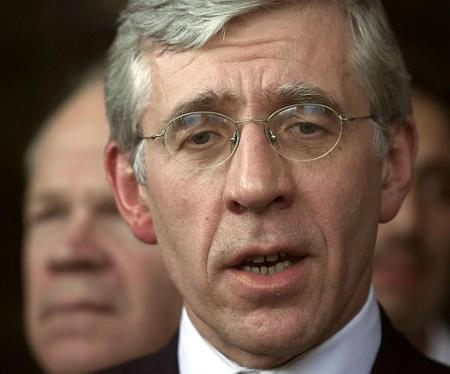

In [34]:
cv2_imshow(imgBingo, )

In [35]:
imgBingo.shape, imgBingo.shape[1]

((374, 450, 3), 450)

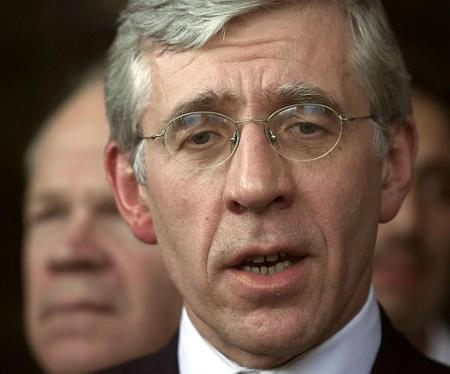

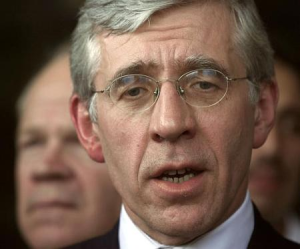

In [36]:
cv2_imshow(imgBingo)

scale=1.5
w = int(imgBingo.shape[1] / scale)
image = imutils.resize(imgBingo, width=w)
cv2_imshow(image)

Our image_pyramid function accepts three parameters as well:

* **image:** The input image for which we wish to generate multi-scale representations.
***scale:** Our scale factor controls how much the image is resized at each layer. Smaller scale values yield more layers in the pyramid, and larger scale values yield fewer layers.
***minSize:** Controls the minimum size of an output image (layer of our pyramid). This is important because we could effectively construct progressively smaller scaled representations of our input image infinitely. Without a minSize parameter, our while loop would continue forever (which is not what we want).

In [37]:
image_pyramid(imgBingo)

<generator object image_pyramid at 0x7ee5509148b0>

In [38]:
#image_pyramid(imgBingo).__next__()
image_pyramid(imgBingo)
#Reminder `def image_pyramid(image, scale=1.5, minSize=(224, 224)):`

<generator object image_pyramid at 0x7ee5509149a0>

In [39]:
len(list(image_pyramid(imgBingo)))

2

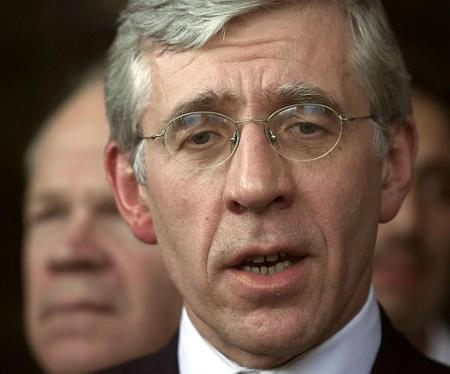

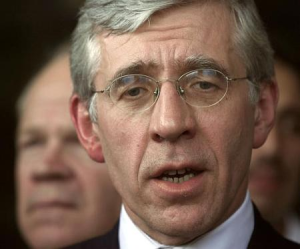

In [40]:
for img in image_pyramid(imgBingo):
  #cv2_imshow(imgBingo)
  cv2_imshow(img)

(186, 224)
(186, 224, 3)


(185, 224)
(185, 224, 3)


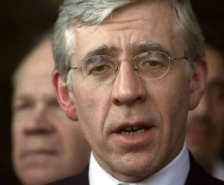

In [41]:
for orig in image_pyramid(imgBingo):

  orig = imutils.resize(orig, width=WIDTH)
  (H, W) = orig.shape[:2]
  print((H, W))
  print(orig.shape)
  cv2_imshow(orig)

###LOAD imported ```JaybaselineCNN36_224VGG``` Keras MODEL
```def Jay_baseline_CNN42_448VGGnet():
model =keras.Sequential(name='JaybaselineCNN_W32cL5_224VGG') # Our model  is initialized using the Sequential  API
  [...]
  * Total layers: 21
  * Weigth: len(Jay_baseline_CNN_W34cL5_224VGGnet().weights)...32
  *Total params: 7,606,487 (29.02 MB)
  *Trainable params: 7,605,943 (29.01 MB)
  *Non-trainable params: 544 (2.12 KB)
```
```
from keras.models import load_model
from keras import backend as K

l_kJmodel = load_model('./model/k_Jmodel.h5')
print(l_kJmodel.outputs)
```

In [42]:
pwd

'/content/CNN2objDetect'

In [43]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py


In [45]:
os.path.exists('/content/drive/MyDrive/model.zip')

True

In [46]:
os.path.exists('/content/CNN2objDetect/model.zip')

False

In [47]:
if not os.path.exists('/content/CNN2objDetect/model.zip'):
  !cp '/content/drive/MyDrive/model.zip' 'model.zip'

In [48]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py
model.zip


In [49]:
os.path.isdir('/content/CNN2objDetect/model')

False

In [50]:
#load model.zip  in CNN2objDetect directory and unzip
if not os.path.isdir('/content/CNN2objDetect/model'):
  !unzip model.zip

Archive:  model.zip
  inflating: model/k_Jmodel.h5       
  inflating: model/keras_Jmodel.keras  


In [51]:
ls

19/                        model.zip
centroidtracker.py         originalPics/
detect_with_classifier.py  pandasINTELdataFFHQconcat_Preprocessing.py
evaluation.tgz             pSplit__FFHQpartition.py
FDDB-folds/                pyimagesearch/
FDDB-folds.tgz             README.md
model/                     test_dataJay_INTELobj_retrieval.py


In [52]:
ls model

keras_Jmodel.keras  k_Jmodel.h5


In [53]:
from keras.models import load_model
from keras import backend as K

# load our network weights from file k_Jmodel.h5
print("[INFO] loading network...")

model = ResNet50(weights="imagenet", include_top=True)

DJSc_model = load_model('./model/k_Jmodel.h5')


[INFO] loading network...
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### `DJSc_model` Model EXPLORATION

In [54]:
DJSc_model.outputs

[<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_407>]

In [55]:
print(DJSc_model.outputs)

[<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_407>]


In [56]:
DJSc_model.output_shape

(None, 7)

In [57]:
DJSc_model.count_params()

7606487

In [58]:
#DJSc_model.name_scope #AttributeError: 'Sequential' object has no attribute 'name_scope'

In [59]:
DJSc_model.summary()

Model: "JaybaselineCNN_W32cL5_224VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay1layer (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay2layer (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay3layer (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay4layer (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay5layer (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay6layer (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay7layer (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay8layer (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay9layer (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ jay10layer (Conv2D)             │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,606,489 (29.02 MB)

 Trainable params: 7,605,943 (29.01 MB)

 Non-trainable params: 544 (2.12 KB)

 Optimizer params: 2 (12.00 B)

In [60]:
#from google.colab import files
#files.upload()

#simple-object-tracking.zip
#from C:\Users\JayMnM\LOCAL_GgleDrv\DataSc\selfTUTORIALs\ImgVdo_jayTUTOR_ARosebrook\4Colab

In [61]:
pwd

'/content/CNN2objDetect'

In [62]:
os.path.isdir('/content/CNN2objDetect')

True

In [63]:
if not os.path.isdir('/content/CNN2objDetect'):
  cd /content/CNN2objDetect

In [64]:
pwd

'/content/CNN2objDetect'

In [65]:
ls

19/                        model.zip
centroidtracker.py         originalPics/
detect_with_classifier.py  pandasINTELdataFFHQconcat_Preprocessing.py
evaluation.tgz             pSplit__FFHQpartition.py
FDDB-folds/                pyimagesearch/
FDDB-folds.tgz             README.md
model/                     test_dataJay_INTELobj_retrieval.py


In [66]:
#!python detect_with_classifier.py --image ./originalPics/2002/07/20/big/img_720.jpg --size "(300, 150)"

[INFO] loading network...
Used model is ... JaybaselineCNN_W32cL5_224VGG
imgBingo shape is ... (449, 299, 3)


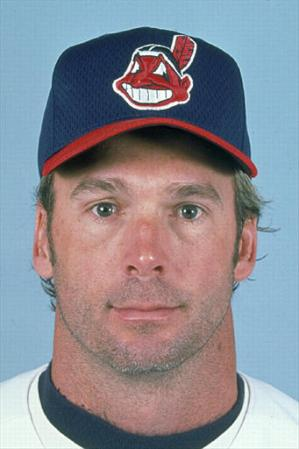

imgBingo is to resize to Width...300 & Height...300
imgBingo is to resize to ...(300, 300)
imgBingo resized shape is ...(300, 199, 3)
imgBingo is NOW resized to imgBingo_rsz to (Height ,Width)... (300, 199)


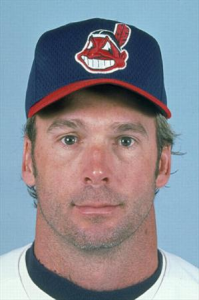

In [67]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# load our network weights from disk
print("[INFO] loading network...")

#Model SUBSTITUTION ...
#model = ResNet50(weights="imagenet", include_top=True)
#model= DJSc_model

print( 'Used model is ...', DJSc_model.name )

# load the input image from disk, resize it such that it has the supplied width,
# and then grab its dimensions
#orig = cv2.imread(args["image"])
imgBingo_path=np.random.choice(imgDIR_path_list)
imgBingo = cv2.imread(imgBingo_path)

print('imgBingo shape is ...', imgBingo.shape)
cv2_imshow(imgBingo)
#orig = imutils.resize(imgBingo, width=WIDTH)
jayHEIGHT=300
jayWIDTH=300
jay_reSIZE=(jayHEIGHT, jayWIDTH)
print('imgBingo is to resize to Width...{} & Height...{}'.format(jayHEIGHT, jayWIDTH) )
print('imgBingo is to resize to ...{}'.format(jay_reSIZE) )
#imgBingo_rsz = imutils.resize(imgBingo, height=jayHEIGHT, width=jayWIDTH) #DJSc Not happy with the reult!!...Review...def resize `if` not exhaustive
#imgBingo_rsz = imutils.resize(imgBingo)
imgBingo_rsz = imutils.resize(imgBingo, height=jayHEIGHT) #DJSc Not happy with the reult!!...Review...def resize `if` not exhaustive
print('imgBingo resized shape is ...{}'.format(imgBingo_rsz.shape) )
#(H, W) = orig.shape[:2]
(jH, jW) = imgBingo_rsz.shape[:2]
print('imgBingo is NOW resized to imgBingo_rsz to (Height ,Width)...', (jH, jW) )
cv2_imshow(imgBingo_rsz)

blCk59_Line3 loads ResNet pre-trained on ImageNet.
**If you choose to use a different pre-trained classifier, you can substitute one here for your particular project.**

To learn how to train your own classifier, I suggest you read [Deep Learning for Computer Vision with Python.](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/)

We also load our input --image. Once it is loaded, we resize it (while maintaining aspect ratio according to our constant WIDTH) and grab resulting image dimensions.

From here, we’re ready to initialize our ***image pyramid generator object:**


In [68]:
imgBingo_path.dtype #OUTPUT: dtype('<U41') [2025Apr5th REVIEW] path weird data type considered as 'NoneType'
#imgBingo_path=str(imgBingo_path) #(2025Apr5th REVIEW) cast to string
#imgBingo_path

dtype('<U41')

REMINDER
```
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	return image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		return image


```

In [69]:
PYR_SCALE

1.2

In [70]:
ROI_SIZE

(224, 224)

In [71]:
imgBingo.shape

(449, 299, 3)

In [72]:
# initialize the image pyramid
#pyramid = image_pyramid(imgBingo_rs, scale=PYR_SCALE, minSize=ROI_SIZE) #

#pyramid = image_pyramid(imgBingo, scale=PYR_SCALE, minSize=ROI_SIZE)
pyramid = image_pyramid(imgBingo)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [73]:
pyramid # strangely non-persistent objet as yielded items disappears.

<generator object image_pyramid at 0x7ee54c0fd8a0>

In [74]:
pyrList=[img for img in pyramid]
pyrList # strangely non-persistent objet as yielded items disappears...to have empty list after few seconds

[array([[[189, 166, 121],
         [201, 178, 133],
         [199, 176, 131],
         ...,
         [208, 184, 138],
         [204, 180, 134],
         [200, 176, 130]],
 
        [[196, 173, 128],
         [208, 185, 140],
         [206, 183, 138],
         ...,
         [209, 185, 139],
         [206, 182, 136],
         [201, 177, 131]],
 
        [[195, 172, 127],
         [207, 184, 139],
         [205, 182, 137],
         ...,
         [210, 186, 140],
         [206, 182, 136],
         [202, 178, 132]],
 
        ...,
 
        [[232, 239, 226],
         [244, 251, 238],
         [242, 249, 236],
         ...,
         [244, 247, 238],
         [250, 253, 244],
         [230, 233, 224]],
 
        [[241, 248, 235],
         [252, 255, 246],
         [251, 255, 245],
         ...,
         [244, 247, 238],
         [250, 253, 244],
         [230, 233, 224]],
 
        [[219, 226, 213],
         [231, 238, 225],
         [229, 236, 223],
         ...,
         [230, 235, 226],
  

In [75]:
len(pyrList)

1

In [76]:
imgBingo.shape

(449, 299, 3)

In [77]:
for img in pyramid:
  img.shape
  cv2_imshow(img)

On Line 45, we supply the necessary parameters to our image_pyramid generator function. Given that pyramid is a generator object at this point, we can loop over values it produces.

Before we do just that, Lines 50 and 51 initialize two lists:

rois: Holds the regions of interest (ROIs) generated from pyramid + sliding window output
locs: Stores the (x, y)-coordinates of where the ROI was in the original image
And we also set a start timestamp so we can later determine how long our classification-based object detection method (given our parameters) took on the input image (Line 55).

https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

Let’s loop over each image our pyramid produces:

**imagePyramid Loop REFERENCE**
```
# loop over the image pyramid
for image in pyramid:
  #looping start above...
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = jW / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi) #L80
		locs.append((x, y, x + w, y + h))

```

In [78]:
(jH,jW)

(300, 199)

In [79]:
imgBingo.shape, imgBingo.shape[1]

((449, 299, 3), 299)

In [80]:
Jscale=jW / float(imgBingo.shape[1])
Jscale

0.6655518394648829

In [81]:
# loop over the image pyramid
for image in pyramid:
  #looping start above L58
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = jW / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi) #L80
		locs.append((x, y, x + w, y + h)) #L81

Looping over the layers of our image pyramid begins on Line 58.

Our first step in the loop is to compute the scale factor between the original image dimensions (W) and current layer dimensions (image.shape[1]) of our pyramid (Line 61). We need this value to later upscale our object bounding boxes.

Now we’ll cascade into our sliding window loop from this particular layer in our image pyramid. Our sliding_window generator allows us to look side-to-side and up-and-down in our image. For each ROI that it generates, we’ll soon apply image classification.

Line 65 defines our loop over our sliding windows. Inside, we:
* Scale coordinates (Lines 68-71).
*Grab the ROI and preprocess it (Lines 75-77). Preprocessing includes resizing to the CNN’s required INPUT_SIZE, converting the image to array format, and applying Keras’ preprocessing convenience function. This includes adding a batch dimension, converting from RGB to BGR, and zero-centering color channels according to the ImageNet dataset.
*Update the list of rois and associated locs coordinates (Lines 80 and 81).

We also handle optional visualization:

In [82]:
model.name

'resnet50'

REFERENCE
```
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()

ap.add_argument("-i", "--image", required=True,
	help="path to the input image")

ap.add_argument("-s", "--size", type=str, default="(200, 150)",
	help="ROI size (in pixels)")

ap.add_argument("-c", "--min-conf", type=float, default=0.9,
	help="minimum probability to filter weak detections")

ap.add_argument("-v", "--visualize", type=int, default=-1,
	help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args())
```

#### PREDICTION with `Resnet50`

Here, we visualize both the original image with a green box indicating where we are “looking” and the resized ROI, which is ready for classification (Lines 85-95). As you can see, we’ll only --visualize when the flag is set via the command line.

Next, we’ll (1) check our benchmark on the pyramid + sliding window process, (2) classify all of our rois in batch, and (3) decode predictions:

length list rois is 1
length locs is 1


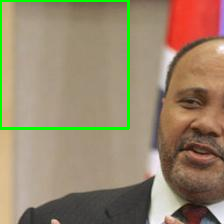

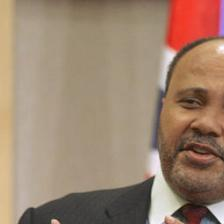

length list rois is 2
length locs is 2


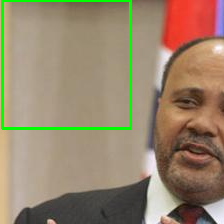

length list rois is 3
length locs is 3


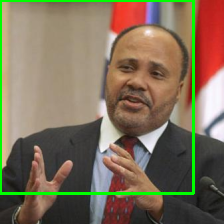

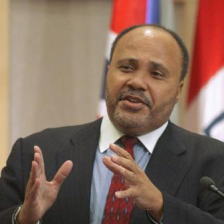

length list rois is 4
length locs is 4


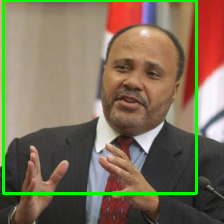

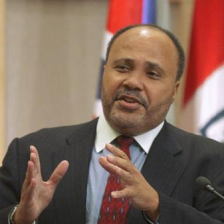

[INFO] looping over pyramid/windows took 0.13126 seconds
[INFO] classifying ROIs...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[INFO] classifying ROIs took 5.24704 seconds
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
preds array looks like... [[('n04350905', 'suit', np.float32(0.6104692))], [('n04350905', 'suit', np.float32(0.6029399))], [('n04350905', 'suit', np.float32(0.5664821))], [('n04350905', 'suit', np.float32(0.40505353))]]
p[0]_0 looks like... ('n04350905', 'suit', np.float32(0.6104692))
p[0]_1 looks like... ('n04350905', 'suit', np.float32(0.6029399))
p[0]_2 looks like... ('n04350905', 'suit', np.float32(0.5664821))
p[0]_3 looks like... ('n04350905', 'suit', np.float32(0.40505353))


In [83]:

#with Resnet50

# loop over the image pyramid
# strangely non-persistent pyramid objet as yielded items disappear...to have empty list after few seconds

# initialize the image pyramid
#pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
imgBingo4jay_path=np.random.choice(imgDIR_path_list)
imgBingo4jay = cv2.imread(imgBingo4jay_path)
pyramid4jay = image_pyramid(imgBingo4jay)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image

rois=[]
#rois = list([]) ## list Reinforcement is CRUCIAL to avoid error
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

for img in pyramid4jay:
  count=1 #DJSc_count
  scale=jW / float(img.shape[1])
  for (x, y, roiOrig) in sliding_window(img, WIN_STEP, ROI_SIZE):
    if count>2:
      break
    # scale the (x, y)-coordinates of the ROI with respect to the
    #*original* image dimensions
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    # take the ROI and preprocess it so we can later classify
    # the region using Keras/TensorFlow
    roi = cv2.resize(roiOrig, INPUT_SIZE)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our list of ROIs and associated coordinates
    rois.append(roi)
    #list(rois).append(roi) #DJSc_debug...reinforced rois as list at declaration
    print(f'length list rois is {len(list(rois))}') #DJSc_test
    locs.append((x, y, x + w, y + h))
    print(f'length locs is {len(locs)}') #DJSc_test

  #Handling optional visualisation
    visual=1

    # check to see if we are visualizing each of the sliding
    # windows in the image pyramid
    #if args["visualize"] > 0:
    if visual > 0:
      clone=roiOrig.copy()
      # clone the original image and then draw a bounding box
	    # surrounding the current region
	    #clone = orig.copy()
      cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
      #show the visualization and current ROI
      cv2_imshow(clone)
      cv2_imshow(roiOrig)
      count+=1
      #cv2.waitKey(0) #ERROR
      #error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error)
      #The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support.
      #If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'

    #Above, we visualize both the original image with a green box indicating where we are “looking” and the resized ROI, which is ready for classification (Lines 85-95).
      #As you can see, we’ll only --visualize when the flag is set via the command line.
    if len(rois)==0:
      print(f'rois array is EMPTY as length is {len(rois)}') #DJSc_test
      break

  #Next, we’ll (1) check our benchmark on the pyramid + sliding window process,
    #(2) classify all of our rois in batch, and (3) decode predictions:

  # show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took

print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)

#Finally, Line 117 below decodes the predictions, grabbing only the top prediction for each ROI.
preds = imagenet_utils.decode_predictions(preds, top=1)

#We’ll need a means to map class labels (keys) to ROI locations associated with that label (values);
#the labels dictionary (Line 118) serves that purpose.

#Let’s go ahead and populate our labels dictionary now:
labels = {}
# loop over the predictions
print(f'preds array looks like... {preds}')
for (i, p) in enumerate(preds):
  # grab the prediction information for the current ROI
  (imagenetID, label, prob) = p[0]
  print(f'p[0]_{i} looks like... {p[0]}')
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
  #if prob >= args["min_conf"]:
  if prob >= 0.4:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
    box = locs[i]
		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
    L = labels.get(label, [])
    L.append((box, prob))
    labels[label] = L

#### PREDICTION with `DJSc_model`

In [84]:
DJSc_model.predict(rois)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


array([[0.11741313, 0.48039547, 0.08941549, 0.0363025 , 0.08948386,
        0.03583276, 0.15115686],
       [0.11092777, 0.44813883, 0.07773593, 0.03803395, 0.09727961,
        0.03847445, 0.18940943],
       [0.1030421 , 0.0429699 , 0.17504913, 0.05123192, 0.10430702,
        0.10571135, 0.4176886 ],
       [0.12554336, 0.04105557, 0.16642156, 0.04795215, 0.10595603,
        0.10824224, 0.40482906]], dtype=float32)

In [85]:
#DJSc_model.predict_classes(rois)
#/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:
#`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
#OUTPUT array([6])
np.argmax(DJSc_model.predict(rois), axis=-1)[0] #replacing DJSc_model.predict_classes(rois)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


np.int64(1)

In [86]:
#print(np.argmax(DJSc_model.predict(rois), axis=-1)[0]) #replacing DJSc_model.predict_classes(rois)

In [87]:
def prepaReshape(image):
    imageSize = 224
    #imageArray = cv2.imread(filePath)
    #newImageArray = cv2.resize(image, (imageSize, imageSize))
    #return newImageArray.reshape(-1, imageSize, imageSize, 3)
    return image.reshape(-1, imageSize, imageSize, 3)

In [232]:
classJay={0:'sea', 1:'HumanFace', 2:'street', 3:'glacier', 4:'mountain', 5:'forest' , 6:'buildings' }
classJay  #labels #COOL

{0: 'sea',
 1: 'HumanFace',
 2: 'street',
 3: 'glacier',
 4: 'mountain',
 5: 'forest',
 6: 'buildings'}

roi shape is (224, 224, 3)
prep_roi shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
roi_0 label prediction is HumanFace


roi shape is (224, 224, 3)
prep_roi shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
roi_1 label prediction is HumanFace


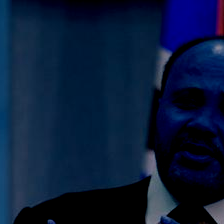

roi shape is (224, 224, 3)
prep_roi shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
roi_2 label prediction is buildings


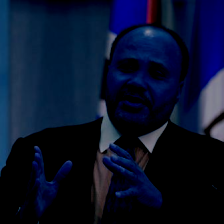

roi shape is (224, 224, 3)
prep_roi shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
roi_3 label prediction is buildings


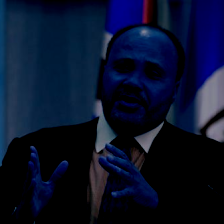

In [439]:
#with DJSc_model

from keras import backend as K
 # initialize our list of output images
images = []
#jayAdd for evaluation metrics
testYtrack=[]
predsTrack=[]
failure=0
# randomly select a few testing items in rois

if len(rois)==0:
  print(f'rois array is EMPTY as length is {len(rois)}') #DJSc_test

#for i in tqdm(np.random.choice(np.arange(0, len(testY)), size=(imgNum,))):
i=0
for roi in rois:
  print(f'roi shape is {roi.shape}')
  #prepare the image roi...CRUCIAL...!!!
  prep_roi=prepaReshape(roi)
  # classify the
  print(f'prep_roi shape is {prep_roi.shape}')
  probs = DJSc_model.predict(prep_roi) #array of probabilities for each of the 7 classes
  prediction = probs.argmax(axis=1) # class'index of the highest probability
  #label = labelNames[prediction[0]]
  label=classJay[prediction[0]]  #
  print(f'roi_{i} label prediction is {label}')
  cv2_imshow(roi)
  i+=1


#**Load TRAIN and TEST datasets...then Merge** (FFHQ & INTEL)

##**Load TRAIN and TEST Datasets Flickr-Faces-HQ Dataset (FFHQ)**


### Flickr-Faces-HQ Dataset (FFHQ) **DATA `thumbnails128x128` DOWNLOAD**

In [90]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [91]:
pwd

'/content/CNN2objDetect'

In [92]:

#UnComment Block-code when 'thumbnails128x128.zip' folder not in gdrive
#files.upload()
#path is /content/gdrive/MyDrive/thumbnails128x128.zip
#path='/content/gdrive/MyDrive/thumbnails128x128.zip'
!cp -r '/content/gdrive/MyDrive/thumbnails128x128.zip' 'thumbnails128x128.zip'
!unzip -q thumbnails128x128.zip

In [93]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py
model/                     thumbnails128x128/
model.zip                  thumbnails128x128.zip


###**METADATA Leverage & Objects `obj` CREATION** [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset)
https://github.com/NVlabs/ffhq-dataset



In [94]:
!wget https://raw.githubusercontent.com/NVlabs/ffhq-dataset/master/download_ffhq.py

--2025-04-19 12:05:09--  https://raw.githubusercontent.com/NVlabs/ffhq-dataset/master/download_ffhq.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23829 (23K) [text/plain]
Saving to: ‘download_ffhq.py’

download_ffhq.py    100%[===================>]  23.27K  --.-KB/s    in 0s      

2025-04-19 12:05:09 (92.6 MB/s) - ‘download_ffhq.py’ saved [23829/23829]



In [95]:
ls

19/                        originalPics/
centroidtracker.py         pandasINTELdataFFHQconcat_Preprocessing.py
detect_with_classifier.py  pSplit__FFHQpartition.py
download_ffhq.py           pyimagesearch/
evaluation.tgz             README.md
FDDB-folds/                test_dataJay_INTELobj_retrieval.py
FDDB-folds.tgz             thumbnails128x128/
model/                     thumbnails128x128.zip
model.zip


In [96]:
!python download_ffhq.py -h

usage: download_ffhq.py [-h] [-j] [-s] [-i] [-t] [-w] [-r] [-a]
                        [--num_threads NUM] [--status_delay SEC]
                        [--timing_window LEN] [--chunk_size KB]
                        [--num_attempts NUM] [--random-shift SHIFT]
                        [--retry-crops] [--no-rotation] [--no-padding]
                        [--source-dir DIR]

Download Flickr-Face-HQ (FFHQ) dataset to current working directory.

options:
  -h, --help            show this help message and exit
  -j, --json            download metadata as JSON (254 MB)
  -s, --stats           print statistics about the dataset
  -i, --images          download 1024x1024 images as PNG (89.1 GB)
  -t, --thumbs          download 128x128 thumbnails as PNG (1.95 GB)
  -w, --wilds           download in-the-wild images as PNG (955 GB)
  -r, --tfrecords       download multi-resolution TFRecords (273 GB)
  -a, --align           recreate 1024x1024 images from in-the-wild images
  --num_threads NUM     

####**CONTINGENCY** Download **PLAN** of missing json file ```./ffhq-dataset-v2.json``` for FFHQ_object generation.

**!!!...Add download link from my ONE_Drive...!!!** to replace gglDriveMounting!!

**```ffhq-dataset-v2.json```** for object generation (metadata)

In [97]:
import json

# read file ##crucial json meta data file
#with open('./gdrive/MyDrive/ffhq-dataset-v2.json', 'r') as myfile:
#above code Not needed if <!cp '/content/gdrive/My Drive/ffhq-dataset-v2.json' 'ffhq-dataset-v2.json'> executed...
with open('/content/gdrive/MyDrive/ffhq-dataset-v2.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

# show values
print("Image index: " + str(obj['0']))
#print("Info about the aligned 1024x1024 image: " + str(obj["image"]))
print("Info about the 128x128 thumbnail: " + str(obj['0']['thumbnail']))

Image index: {'category': 'training', 'metadata': {'photo_url': 'https://www.flickr.com/photos/frumkin/1133484654/', 'photo_title': 'DSCF0899.JPG', 'author': 'Jeremy Frumkin', 'country': '', 'license': 'Attribution-NonCommercial License', 'license_url': 'https://creativecommons.org/licenses/by-nc/2.0/', 'date_uploaded': '2007-08-16', 'date_crawled': '2018-10-10'}, 'image': {'file_url': 'https://drive.google.com/uc?id=1xJYS4u3p0wMmDtvUE13fOkxFaUGBoH42', 'file_path': 'images1024x1024/00000/00000.png', 'file_size': 1488194, 'file_md5': 'ddeaeea6ce59569643715759d537fd1b', 'pixel_size': [1024, 1024], 'pixel_md5': '47238b44dfb87644460cbdcc4607e289', 'face_landmarks': [[131.62, 453.8], [142.86, 535.23], [154.31, 612.62], [179.63, 687.47], [230.76, 747.47], [298.2, 788.88], [375.17, 817.84], [439.1, 848.56], [500.96, 856.54], [554.19, 843.07], [600.26, 811.44], [652.7, 781.75], [697.13, 734.68], [725.95, 676.3], [738.9, 612.28], [743.77, 547.84], [747.8, 484.17], [260.97, 406.18], [312.64, 375

In [238]:
obj['1']['metadata']

{'photo_url': 'https://www.flickr.com/photos/cybershaman/3672176948/',
 'photo_title': '.sunday | funday',
 'author': 'Cyber Shaman',
 'country': 'United States',
 'license': 'Attribution License',
 'license_url': 'https://creativecommons.org/licenses/by/2.0/',
 'date_uploaded': '2009-06-29',
 'date_crawled': '2018-10-10'}

In [99]:
obj['0']['thumbnail']['file_path']

'thumbnails128x128/00000/00000.png'

In [100]:
obj['0']['thumbnail']['file_path']

'thumbnails128x128/00000/00000.png'

###Pics DISPLAY Check

In [101]:
#DJSc_check
from google.colab.patches import cv2_imshow
img650=obj['650']['image']['face_landmarks']
#cv2_imshow(img650) # AttributeError: 'list' object has no attribute 'clip'
import numpy as np
img650_uint=np.array(img650).astype('uint8') # rounding arrays to int
img650_uint
cv2_imshow(img650_uint)

In [102]:
len(obj)

70000

  0%|          | 0/20 [00:00<?, ?it/s]

enum is 17582
./thumbnails128x128/17582.png
enum is 10105
./thumbnails128x128/10105.png
enum is 47841
./thumbnails128x128/47841.png


 15%|█▌        | 3/20 [00:00<00:00, 21.45it/s]

enum is 15650
./thumbnails128x128/15650.png
enum is 10070
./thumbnails128x128/10070.png


 30%|███       | 6/20 [00:00<00:00, 22.38it/s]

enum is 11567
./thumbnails128x128/11567.png
enum is 1420
./thumbnails128x128/01420.png
enum is 972
./thumbnails128x128/00972.png


 45%|████▌     | 9/20 [00:00<00:00, 23.63it/s]

enum is 31174
./thumbnails128x128/31174.png
enum is 18464
./thumbnails128x128/18464.png


 60%|██████    | 12/20 [00:00<00:00, 22.70it/s]

enum is 23163
./thumbnails128x128/23163.png
enum is 19848
./thumbnails128x128/19848.png
enum is 2447
./thumbnails128x128/02447.png
enum is 25173
./thumbnails128x128/25173.png
enum is 39033
./thumbnails128x128/39033.png


 75%|███████▌  | 15/20 [00:00<00:00, 22.92it/s]

enum is 2281
./thumbnails128x128/02281.png
enum is 15983
./thumbnails128x128/15983.png
enum is 56229
./thumbnails128x128/56229.png


100%|██████████| 20/20 [00:00<00:00, 23.93it/s]


enum is 25995
./thumbnails128x128/25995.png
enum is 34309
./thumbnails128x128/34309.png


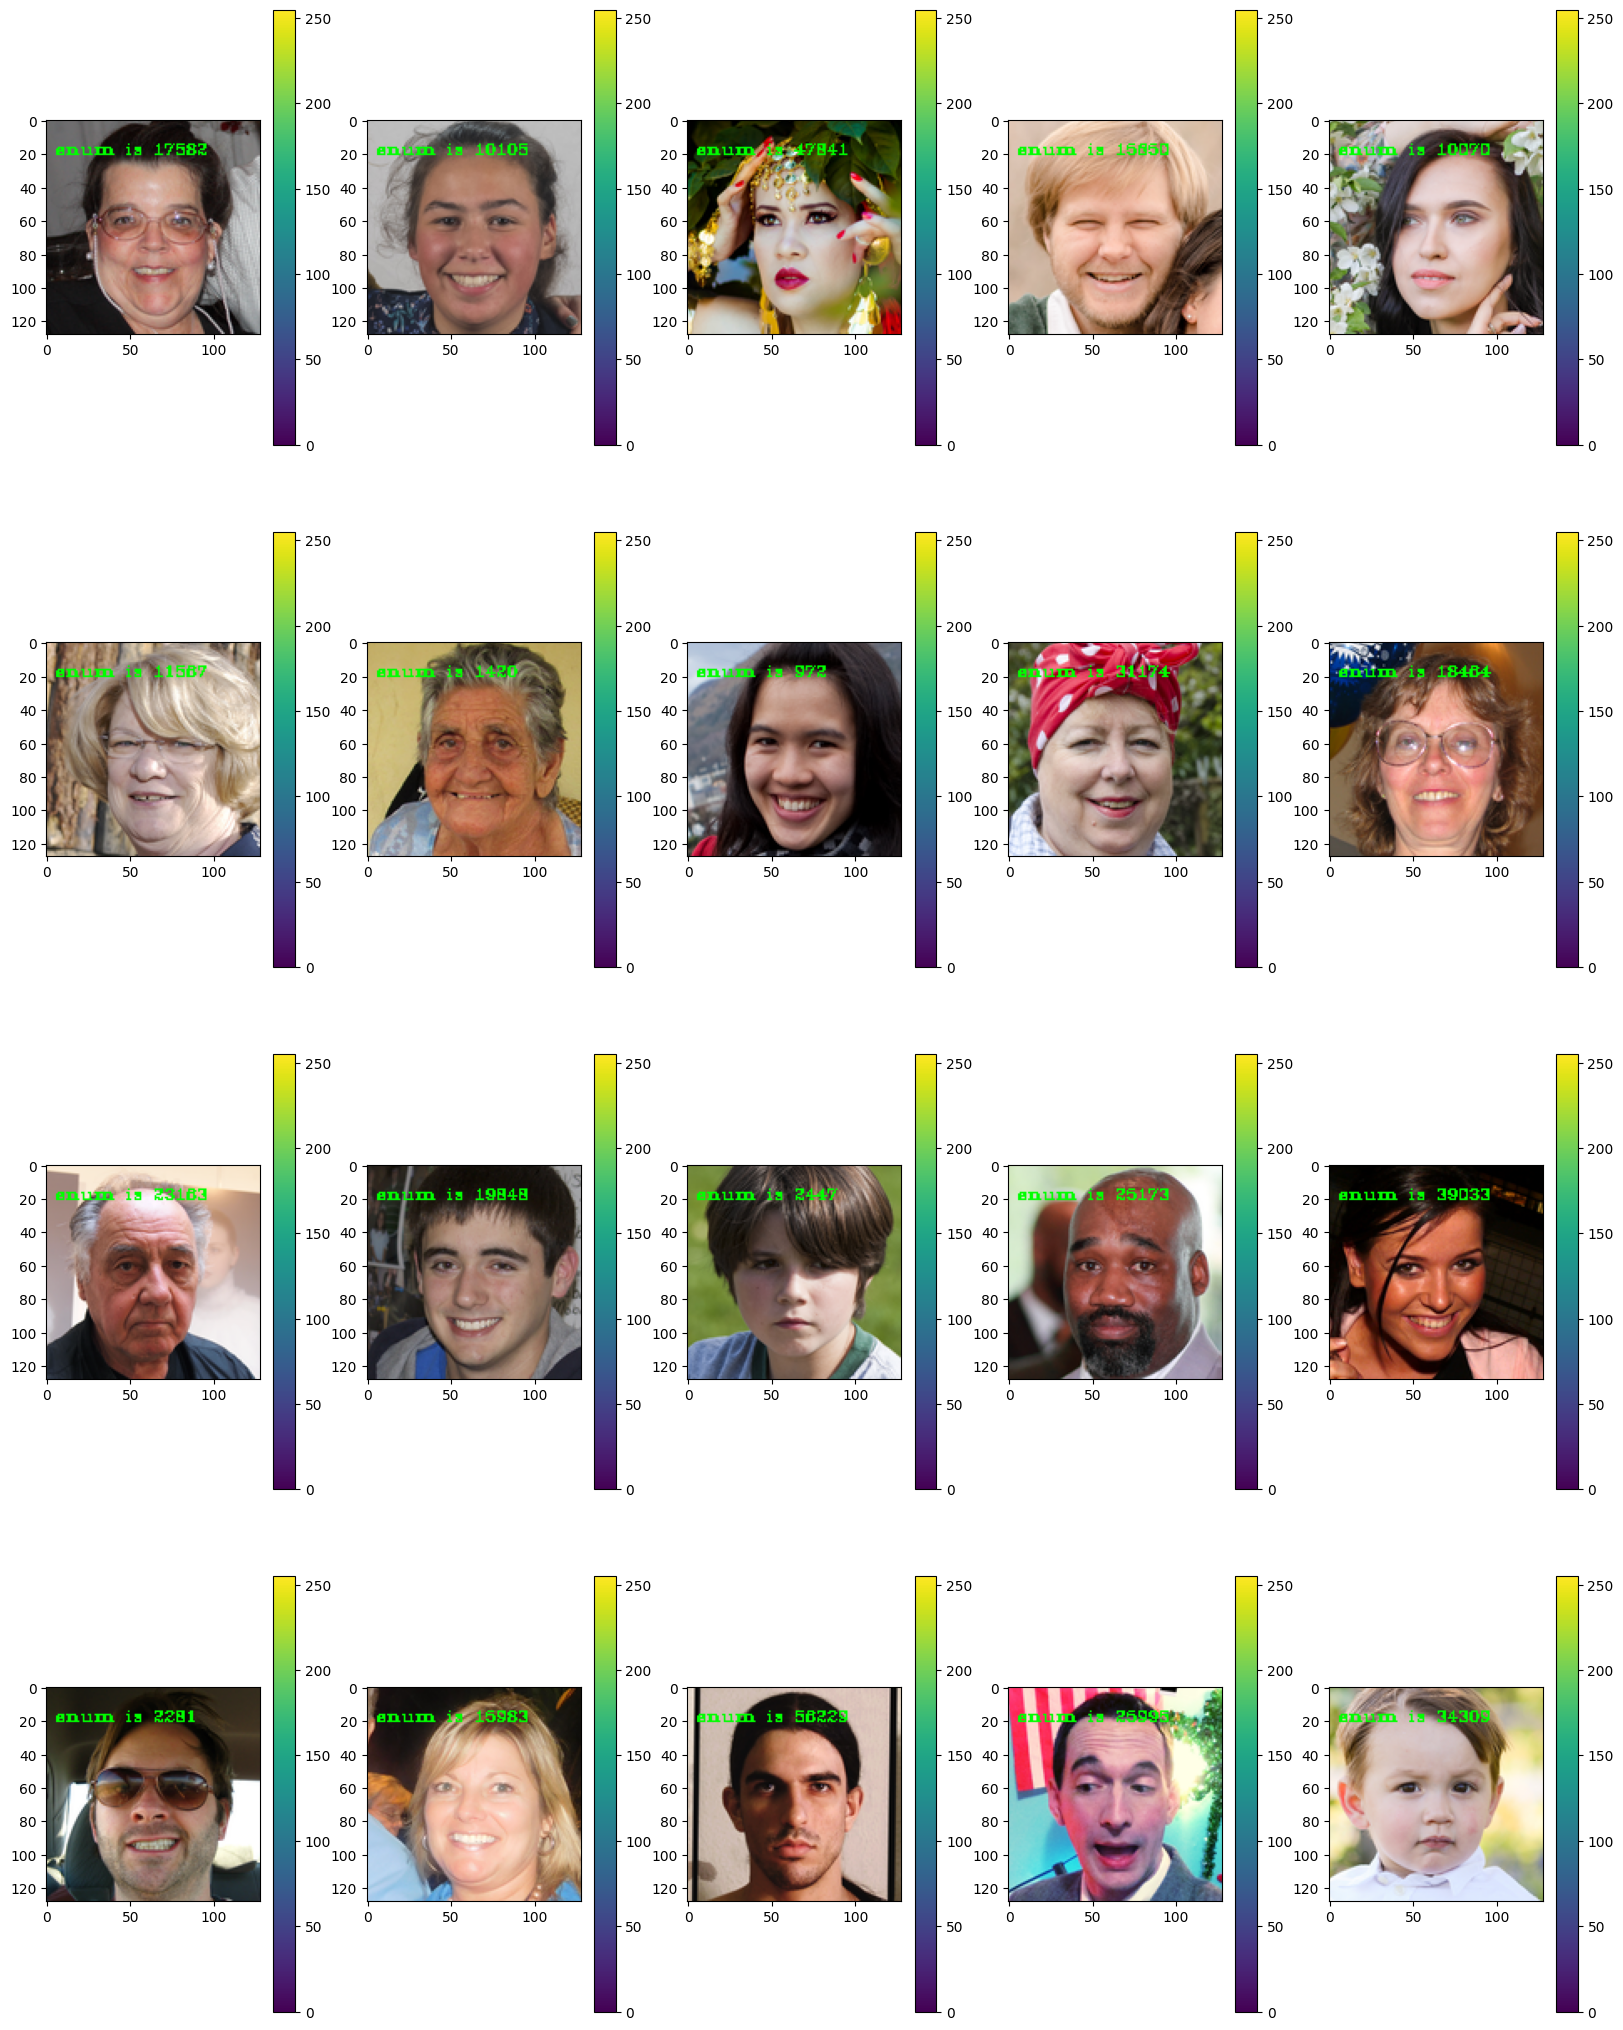

In [103]:
import random
#randomR=random.choice(range(0,len(obj),11))

i=0
imgNum=20
#imgNum=int(call__imgNumJayForm())

plt.figure(figsize=(20,26))
#for i in range(len(obj)):

for enum in tqdm(np.random.choice(np.arange(0, len(obj)), size=(imgNum,))):
      #retrieve full_path
  print('enum is {enum}'.format(enum=enum))
  thumb_filePath= obj[str(enum)]['thumbnail']["file_path"]
  #image_filePath= obj[str(enum)]['image']["file_path"]
      #read image via full_path

  thumb_ext=thumb_filePath.split('/')[-1] #2025Apr4th_REVISION) as metadata from github, but image from flickr
  img_path=f'./thumbnails128x128/{thumb_ext}'
  print(img_path)

  #thumb_ext_num=thumb_ext.split('.')[0] #retrieve extension number to check if in Jenum_list_strZfill# Not needed as no comparison required

  #2025Apr4th_REVISION) above block code as metadata from github ffhq-dataset-v2.json, but image from flickr / or kaggle downloaded
      #read image via full_path
      #below snippet CRUCIAL...when Not All files have been downloaded.

      #if os.path.isfile(thumb_filePath): #2025Apr4th_REVISION)

  if os.path.isfile(img_path):
    imgMatrix = cv2.imread(img_path)

      #below snippet CRUCIAL...when Not All files have been downloaded.

    plt.subplot(imgNum//5, 5, i+1 )

    #plt.figure(figsize=(12,14))
    imgMatrix= cv2.imread(img_path)
    img=cv2.cvtColor(imgMatrix,cv2.COLOR_BGR2RGB)
    cv2.putText(img,f'enum is {enum}',(5,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.50,color=(0,255,0),thickness=1)
    #cv2_imshow(img)
    #plt.imshow(imageMatrix)
    #cv2_imshow(thumb)

    #plt.subplot(imgNum//5, 5, i + 1)
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)

    #plt.imshow(imageMatrix)
    #cv2_imshow(thumb)



    i=i+1

`FilePath` and `picIndex` RETRIEVAL

In [104]:
#`FilePath` and `picIndex` RETRIEVAL
filePath_list=[]
picIndex_list=[]
for elm in tqdm(range(len(obj))):
      #retrieve full_path
  jt_filePath= obj[str(elm)]['thumbnail']["file_path"]
      #read image via full_path

  thumb_ext=jt_filePath.split('/')[-1] #2025Apr4th_REVISION) as metadata from github, but image from flickr
  img_Path=f'./thumbnails128x128/{thumb_ext}'

      #below snippet CRUCIAL...when Not All files have been downloaded.
  if os.path.isfile(img_Path):
    filePath_list.append(img_Path)
    picIndex_list.append(elm)

print('\n Pics Download Expected Amount (PdEa) is: {} \n'.format(len(obj)))
#len(filePath_list)
print('\n Pics download RECEIVED amount (PdRa) is: {} \n'.format(len(filePath_list)))
print('{}% Successfull Fetch'.format(len(filePath_list)/len(obj)*100))

100%|██████████| 70000/70000 [00:00<00:00, 134444.46it/s]


 Pics Download Expected Amount (PdEa) is: 70000 


 Pics download RECEIVED amount (PdRa) is: 70000 

100.0% Successfull Fetch


In [105]:
len(picIndex_list),len(filePath_list)

(70000, 70000)

###**LOAD Train and SPLIT to Test dataset**(FFHQ)

pSplit

```
#partition
def pSplit_partition():
  pSplit=int(input('Please PROVIDE percentage of Reduction for a total of {} Training records:  '.format(len(train_X))))
  trainSel=np.random.choice(np.arange(0,len(train_X)), size=len(train_X)*pSplit//100)
  trainX, trainY=train_X[trainSel], train_y[trainSel]
  return trainX, trainY
```

to_catego
```
from keras.utils import to_categorical
def to_catego(train_y,test_y):
	# one hot encode target values

	trainY = to_categorical(train_y)
	testY = to_categorical(test_y)
	return trainY, testY
```



## self-made METADATA

###**Load TRAIN and TEST datasets INTEL** for self-made METADATA ...
[from kaggle.json Repo ...If...IntelClassImg_GoodOne.zip not unzipped to yield folder (dir) /IntelClassImg_GoodOne]

**!!!...Add download link of [INTEL](https://www.kaggle.com/puneet6060/intel-image-classification) dataset from my ONE_Drive...!!!** to replace gglDriveMounting!!

####GoodOne
IntelClassImg_GoodOne.zip link
https://1drv.ms/u/c/1ceb8815f3cf306e/EW4wz_MViOsggBxSyAAAAAABeo3as1DrEndgt-WQJ0KJJw?e=gxYorS

In [106]:
cp '/content/gdrive/My Drive/IntelClassImg_GoodOne.zip' 'IntelClassImg_GoodOne.zip'

In [107]:
!unzip -q 'IntelClassImg_GoodOne.zip' #to comment once folder is available in 1Drive

In [108]:
ls

19/                        model.zip
centroidtracker.py         originalPics/
detect_with_classifier.py  pandasINTELdataFFHQconcat_Preprocessing.py
download_ffhq.py           pSplit__FFHQpartition.py
evaluation.tgz             pyimagesearch/
FDDB-folds/                README.md
FDDB-folds.tgz             test_dataJay_INTELobj_retrieval.py
IntelClassImg_GoodOne/     thumbnails128x128/
IntelClassImg_GoodOne.zip  thumbnails128x128.zip
model/


In [109]:
ls ./IntelClassImg_GoodOne

NonFace_seg_pred/  NonFace_seg_test/  NonFace_seg_train/


In [110]:
ls ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train

buildings/  forest/  glacier/  mountain/  sea/  street/


###**Training /Test Data PREPARATION & MERGENCE from ...** both Datasets **FFHQ** (Positive Samples) & **INTEL**_classImages (Negative Samples)

**Additional LIBRARIES Import**

In [111]:
#necessary libraries import
import sys
import tensorflow as tf
from tensorflow import keras

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib and seaborn for plotting
import plotly.express as px
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [112]:
#cat test_dataJay_INTELobj_retrieval.py

In [113]:
# For  classes build practices...

#import pandasINTELdataFFHQconcat_Preprocessing
#import test_dataJay_INTELobj_retrieval
#from pSplit_FFHQpartition import pSplit_FFHQ

#from test_dataJay_INTELobj_retrieval import call_INTELobj_retrieval
#from test_dataJay_INTELobj_retrieval import test_dataJay, np_test_labels_list, INTELobj_test

In [114]:
DIR_train= './IntelClassImg_GoodOne/NonFace_seg_train/seg_train' #labelsDirectories
#DIR_train= './seg_train/seg_train'

DIR_test= './IntelClassImg_GoodOne/NonFace_seg_test/seg_test' #labelsDirectories
#DIR_test= './seg_test/seg_test'

In [115]:
def call_INTELcategCard_JayForm(): #@title jayForm
  #@markdown Please INPUT the amount of images for each INTELCategory:
  INTELcategCard=50 #@param{type:'integer'}
  #print(imgNum)
  return INTELcategCard

In [116]:
#FFHQusedTest_Pics_set FFHQ pics path

`def pandasINTELdataFFHQconcat_Preprocessing():`

In [375]:
## **Data CONCAT & Preprocessing with Pandas** SUMMARY
import pandas

def pandasINTELdataFFHQconcat_Preprocessing():


  #FFHQ / INTEL Load&Pandas

  FFHQtrainPics_set, len_FFHQtrainPics_set, FFHQtestPics, len_FFHQtestPics, FFHQusedTest_Pics_set, len_FFHQusedTest_Pics_set, FFHQresTestPics, len_FFHQresTestPics =pSplit__FFHQpartition()

  # ...TRAIN & TEST...#

  #FFHQ (HumFaces)

  print('len_FFHQtrainPics_set is ... ', len_FFHQtrainPics_set)
  print('len_FFHQusedTest_Pics_set is ...', len_FFHQusedTest_Pics_set)

  FFHQtrain_Xdf=pd.DataFrame(FFHQtrainPics_set)
  #FFHQtrain_Xdf
  #FFHQtrain_Xdf.head

  FFHQusedTest_Xdf=pd.DataFrame()
  FFHQusedTest_Xdf['testPath']=FFHQusedTest_Pics_set #index of pics path 2025Apr19_review
  #FFHQusedTest_Xdf
  #FFHQusedTest_Xdf.head

  FFHQtr_classeID=['FFHQtr_{}'.format(i) for i in FFHQtrain_Xdf.index]
  #CIFtr_classeID , FFHQtr_classeID
  FFHQusedTest_classeID=['FFHQusedTest_{}'.format(i) for i in FFHQusedTest_Xdf.index]


#FFHQtrain_Xdf.index
  FFHQtrain_Xdf['jayIndex']=FFHQtrain_Xdf.index
  FFHQusedTest_Xdf['test_jayIndex']=FFHQusedTest_Xdf.index


  FFHQtrain_Xdf['ID']=FFHQtrain_Xdf['jayIndex'].apply(lambda x:FFHQtr_classeID[x])
  #FFHQtrain_Xdf.head
  FFHQtrain_Xdf['SubCateg']='HumanFace'
  #FFHQtrain_Xdf

  FFHQusedTest_Xdf['test_ID']=FFHQusedTest_Xdf['test_jayIndex'].apply(lambda x:FFHQusedTest_classeID[x])
  #FFHQusedTest_Xdf.head
  FFHQusedTest_Xdf['test_SubCateg']='HumanFace'
  #FFHQusedTest_Xdf




  abstract_FFHQtrain_Xdf=FFHQtrain_Xdf[["ID","jayIndex","SubCateg"]]
  #abstract_FFHQtrain_Xdf

  #abstract_FFHQusedTest_Xdf=FFHQusedTest_Xdf[["test_ID","test_jayIndex","test_SubCateg"]]
  abstract_FFHQusedTest_Xdf=FFHQusedTest_Xdf[["test_ID","test_jayIndex","test_SubCateg",'testPath']]
  abstract_FFHQusedTest_Xdf


  #np.array(train_dataJay).shape, len(train_dataJay)
  INTELobj_train.keys()
  #np.array(labels_list)
  INTELobj_test.keys()

#INTEL  (Non Faces) sceneries
  INTELtrain_Xdf=pandas.DataFrame()
  INTELtrain_Xdf['ID']=np_labels_list
  INTELtrain_Xdf['jayIndex']=INTELtrain_Xdf.index
  INTELtrain_Xdf['SubCateg']= INTELtrain_Xdf['ID'].apply(lambda x: x.split('_')[0])
  #INTELtrain_Xdf

  #INTELtest_Xdf=pandas.DataFrame()
  INTELtest_Xdf=pandas.DataFrame()
  INTELtest_Xdf['test_ID']=np_test_labels_list
  INTELtest_Xdf['test_jayIndex']=INTELtest_Xdf.index
  INTELtest_Xdf['test_SubCateg']= INTELtest_Xdf['test_ID'].apply(lambda x: x.split('_')[0])
  INTELtest_Xdf['testPath']=test_INTELpath #test_INTELpath (list of item_full_path) insertion 2025Apr19_review

  INTELtest_Xdf
  len(INTELtrain_Xdf),len(abstract_FFHQtrain_Xdf), len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf)



  len(INTELtrain_Xdf),len(abstract_FFHQtrain_Xdf), len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf)
  len(INTELtest_Xdf),len(abstract_FFHQusedTest_Xdf), len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf)


      # pd.concat([abstract_CIFARtrain_Xdf,abstract_FFHQtrain_Xdf],axis=1) # all indexes included
  mergedTRAIN_INTEL_FFHQ_df=pd.concat([INTELtrain_Xdf,abstract_FFHQtrain_Xdf],axis=0) # all indexes included
  #mergedTRAIN_INTEL_FFHQ_df

  mergedTEST_INTEL_FFHQ_df=pd.concat([INTELtest_Xdf,abstract_FFHQusedTest_Xdf],axis=0) # all indexes included
  mergedTEST_INTEL_FFHQ_df


  print('\n FFHQtrain_Xdf: \n {}'.format(FFHQtrain_Xdf))
  print('\n FFHQusedTest_Xdf: \n {}'.format(FFHQusedTest_Xdf))


  #Readjustment & Mergence (INTEL & FFHQ)

  INTELtrain_Xdf=INTELtrain_Xdf[["ID","jayIndex","SubCateg"]]
  #print('\n abstract_INTELtrain_Xdf is : \n {}'.format(INTELtrain_Xdf))

  #INTELtest_Xdf=INTELtest_Xdf[["test_ID","test_jayIndex","test_SubCateg"]]
  print('\n abstract_INTELtest_Xdf is : \n {}'.format(INTELtest_Xdf))


  abstract_FFHQtrain_Xdf=FFHQtrain_Xdf[["ID","jayIndex","SubCateg"]]
  #print('\n abstract_FFHQtrain_Xdf is: \n {}'.format(abstract_FFHQtrain_Xdf))

  abstract_FFHQusedTest_Xdf=FFHQusedTest_Xdf[["test_ID","test_jayIndex","test_SubCateg", 'testPath']]
  print('\n abstract_FFHQusedTest_Xdf is: \n {}'.format(abstract_FFHQusedTest_Xdf))


  len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf)

  len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf)


  mergedTRAIN_INTEL_FFHQ_df=pd.concat([INTELtrain_Xdf,abstract_FFHQtrain_Xdf],axis=0,ignore_index=True)
  # all indexes included and... ignored to avoid duplication...!!!...crucial
  #print('\n mergedTRAIN_INTEL_FFHQ_df is : \n {}'.format(mergedTRAIN_INTEL_FFHQ_df))

  mergedTEST_INTEL_FFHQ_df=pd.concat([INTELtest_Xdf,abstract_FFHQusedTest_Xdf],axis=0,ignore_index=True)
  #  # all indexes included and... ignored to avoid duplication...!!!...crucial
  print('\n mergedTEST_INTEL_FFHQ_df is : \n {}'.format(mergedTEST_INTEL_FFHQ_df))


  #Check Balances

  #TRAIN
  len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf) == len(mergedTRAIN_INTEL_FFHQ_df)
  print('\n Mergence CheckBalance is : {} as ...\n len(INTELtrain_Xdf) is: {} \n len(abstract_FFHQtrain_Xdf) is {} \
\n len(mergedTRAIN_INTEL_FFHQ_df) is {} '.format((len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf) == len(mergedTRAIN_INTEL_FFHQ_df)),len(INTELtrain_Xdf), len(abstract_FFHQtrain_Xdf),len(mergedTRAIN_INTEL_FFHQ_df)  ))

  #TEST
  len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf) == len(mergedTEST_INTEL_FFHQ_df)
  print('\n Mergence CheckBalance is : {} as ...\n len(INTELtest_Xdf) is: {} \n len(abstract_FFHQusedTest_Xdf) is {} \
\n len(mergedTRAIN_INTEL_FFHQ_df) is {} '.format((len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf) == len(mergedTEST_INTEL_FFHQ_df)),len(INTELtest_Xdf), len(abstract_FFHQusedTest_Xdf),len(mergedTEST_INTEL_FFHQ_df)  ))


  return [INTELtrain_Xdf, len(INTELtrain_Xdf) ,FFHQtrain_Xdf, abstract_FFHQtrain_Xdf, len(abstract_FFHQtrain_Xdf), mergedTRAIN_INTEL_FFHQ_df, len(mergedTRAIN_INTEL_FFHQ_df)] , [INTELtest_Xdf, len(INTELtest_Xdf) ,FFHQusedTest_Xdf, abstract_FFHQusedTest_Xdf, len(abstract_FFHQusedTest_Xdf), mergedTEST_INTEL_FFHQ_df, len(mergedTEST_INTEL_FFHQ_df)]

`train_dataJay_INTELobj_retrieval():`

In [316]:
import numpy as np

def train_dataJay_INTELobj_retrieval():
  train_dataJay=[]
  labels_list=[]
  INTELobj_train={}
  INTELcategCard=call_INTELcategCard_JayForm()

  subCount=0
  for Sub in os.listdir(DIR_train):
    itemCount=0
    Sub_labels_list=[]
    #print(Sub)
    SubPath=os.path.join(DIR_train,Sub)
    print(f'Train_label <{Sub}> path is:  {SubPath}')
    Sub_DIR_train=os.listdir(SubPath)
    for item in Sub_DIR_train:
      if itemCount> INTELcategCard:         # max<700> per category...reduced amount to avoid CRASH!!!
        break
      #REMINDER: INTELcategCard=call_INTELcategCard_JayForm()

      #print(item)
      #print(item_SubPath)
      elif item.endswith('.jpg'):
        #print(item)
        item_fullPath_train=os.path.join(SubPath,item)# or os.path.join(DIR_train,Sub,item)
        #print(item_fullPath_train)
        imageMatrix=cv2.imread(item_fullPath_train)

        imageMatrix_rsz=cv2.resize(imageMatrix, (224,224))
        imageMatrix_rsz_arr=img_to_array(imageMatrix_rsz)
        train_dataJay.append(imageMatrix_rsz_arr) #here... 2be Def RETURN (1)

      # extract the class label from the image path and update the labels list
      label=str(Sub+'_'+item)

      Sub_labels_list.append(label) #....to generate <INTELobj_train[Sub]> subList...???
      labels_list.append(label)

      itemCount+=1


    INTELobj_train[Sub]=Sub_labels_list #here... 2be Def RETURN (2)

    #print(INTELobj_train[Sub])

    #print(INTELobj_train)

    subCount+=1
    #if subcount>1: # reduced count required to avoid ... CRASH!!!!...if needed
    #break

  np_labels_list=np.array(labels_list) #here... 2be in Def RETURN
  #np.array(train_dataJay) ... cause CRASH!!!
  #print(labels_list)
  #print(INTELobj_train)

  return train_dataJay, np_labels_list, INTELobj_train



`def test_dataJay_INTELobj_retrieval():`

In [317]:
#import numpy as np

def test_dataJay_INTELobj_retrieval():
  test_dataJay=[]
  test_labels_list=[]
  INTELobj_test={}
  INTELcategCard=call_INTELcategCard_JayForm()
  test_INTELpath=[]  #test_INTELpath insertion 2025Apr19_review

  subCount=0
  for Sub in os.listdir(DIR_test):
    itemCount=0
    test_Sub_labels_list=[]
    #print(Sub)
    SubPath=os.path.join(DIR_test,Sub)
    print(f'Test_label <{Sub}> path is:  {SubPath}')
    Sub_DIR_test=os.listdir(SubPath)
    for item in Sub_DIR_test:
      if itemCount> INTELcategCard:         # max<700> per category...reduced amount to avoid CRASH!!!
        break

      #print(item)
      #print(item_SubPath)
      elif item.endswith('.jpg'):
        #print(item)
        item_fullPath_test=os.path.join(SubPath,item)# or os.path.join(DIR_train,Sub,item)
        #print(item_fullPath_train)
        test_INTELpath.append(item_fullPath_test) #test_INTELpath insertion 2025Apr19_review
        imageMatrix=cv2.imread(item_fullPath_test)

        imageMatrix_rsz=cv2.resize(imageMatrix, (224,224))
        imageMatrix_rsz_arr=img_to_array(imageMatrix_rsz)
        test_dataJay.append(imageMatrix_rsz_arr) #here... 2be Def RETURN (1)

      # extract the class label from the image path and update the labels list
      label=str(Sub+'_'+item)
      test_Sub_labels_list.append(label)

      test_labels_list.append(label)

      itemCount+=1


    INTELobj_test[Sub]=test_Sub_labels_list #here... 2be Def RETURN (2)

    #print(INTELobj_train[Sub])

    #print(INTELobj_train)

    subCount+=1
    #if subcount>1: # reduced count required to avoid ... CRASH!!!!...if needed
    #break

  np_test_labels_list=np.array(test_labels_list) #here... 2be in Def RETURN
  #np.array(train_dataJay) ... cause CRASH!!!
  #print(labels_list)
  #print(INTELobj_train)

  return test_dataJay, np_test_labels_list, INTELobj_test, test_INTELpath
  #test_INTELpath insertion 2025Apr19_review



`def pSplit__FFHQpartition():`

In [318]:
# FFHQ SPLIT Partition (Train|Test)
def pSplit__FFHQpartition():

  pSplit=float(input('Please PROVIDE a percentage of TRAINING for a total of {} Training-Test records:  '.format(len(filePath_list))))
  train_picIndex_choice=np.random.choice(picIndex_list, size=int((len(filePath_list)*pSplit)//100))
  len(train_picIndex_choice)

  # picsList=[obj[str(num)] for num in picIndex_list]
  # picsList
  # len(picsList)

  train_picIndex_set=set(train_picIndex_choice)

  #CRUCIAL...image path definition as Thumbnails OR Image ...CRUCIAL !!!
  trainPics_set=['./thumbnails128x128/{}'.format(obj[str(enum)]['thumbnail']["file_path"].split('/')[-1]) for enum in train_picIndex_set]
  #len(trainPics_set), trainPics_set[-1], trainPics_set[22089]  #DJSc_testing

  trainPics_set
  print('FFHQTraining Pics Count as {}% Representative...{}'.format(pSplit,len(train_picIndex_choice)))
  print('FFHQTraining Pics Count as Set...{} ... as {}% true representation'.format(len(trainPics_set),len(trainPics_set)*100//len(picIndex_list) ))
  print(len(train_picIndex_choice)-len(trainPics_set), 'representes the amount of duplicated pictures\
  in our random choice...Hence offsetting the value of our Split percentage Repesentative {} ... :-) Never Mind!!'.format(pSplit) )

  #testPics=[obj[str(num)]['image']["file_path"] for num in picIndex_list if num not in train_picIndex_set] #testPics NO Need to be cast as Set!!!
  #print('FFHQTest Pics Count...{}'.format(len(testPics)))
  testPicIndex_list=[num for num in picIndex_list if num not in train_picIndex_set]
  testPics=['./thumbnails128x128/{}'.format(obj[str(enum)]['thumbnail']["file_path"].split('/')[-1]) for enum in testPicIndex_list]
  print('FFHQTest Pics Count...{}'.format(len(testPics)))


  #Test data PARTITIONing@partiSpliTest into used & reserved(res) portions of TestData.
  partiSpliTest=0.01 #TEST Split
  usedTest_picIndex_choice=np.random.choice(testPicIndex_list, size=int(len(testPics)*partiSpliTest))
  len(usedTest_picIndex_choice)

  usedTest_picIndex_set=set(usedTest_picIndex_choice)

  #CRUCIAL...image path definition as Thumbnails OR Image ...CRUCIAL !!!
  usedTest_Pics_set=['./thumbnails128x128/{}'.format(obj[str(enum)]['thumbnail']["file_path"].split('/')[-1]) for enum in usedTest_picIndex_set]
  #trainPics_set=[obj[str(num)]['image']["file_path"] for num in train_picIndex_set]
  usedTest_Pics_set

  print('FFHQusedTest Pics Count as {}% Representative...{}'.format(partiSpliTest*100,len(usedTest_picIndex_choice)))
  print('FFHQusedTest Pics Count as Set...{} ... as {:.2f}% true Representation'.format(len(usedTest_Pics_set),len(usedTest_Pics_set)*100/len(testPicIndex_list) ))
  print(len(usedTest_picIndex_choice)-len(usedTest_Pics_set), 'represents the amount of duplicated pictures\
  in our random choice...Hence offsetting the value of our Partition percentage Repesentative {}% ... :-) Never Mind!!'.format(partiSpliTest*100) )

  resTest_Pics=['./thumbnails128x128/{}'.format(obj[str(enum)]['thumbnail']["file_path"].split('/')[-1]) for enum in testPicIndex_list if enum not in usedTest_picIndex_set]
  #testPics NO Need to be cast as Set!!!


  len(testPics)==len(usedTest_Pics_set) +len(resTest_Pics)
  Total=len(trainPics_set) + len(testPics)

  print('FFHQtrainPics_set Count is ...', len(trainPics_set))
  print('FFHQusedTest_Pics_set Count is ...', len(usedTest_Pics_set))
  print('FFHQresTest_Pics Count is ...', len(resTest_Pics))

  print('{} + {} + {} = {} TotalFFHQ'.format(len(trainPics_set),len(usedTest_Pics_set), len(resTest_Pics), len(trainPics_set) + len(usedTest_Pics_set) + len(resTest_Pics) ))
  print(Total== (len(trainPics_set) + len(usedTest_Pics_set) + len(resTest_Pics)))

  return trainPics_set, len(trainPics_set), testPics, len(testPics),usedTest_Pics_set, len(usedTest_Pics_set), resTest_Pics, len(resTest_Pics) #4x2 (8) returned variables

`train_dataJay_INTELobj_retrieval()`



In [319]:
train_dataJay, np_labels_list, INTELobj_train=train_dataJay_INTELobj_retrieval()
#train_dataJay=train_dataJay_INTELobj_retrieval()[0]

Train_label <sea> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/sea
Train_label <forest> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/forest
Train_label <mountain> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/mountain
Train_label <street> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/street
Train_label <glacier> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/glacier
Train_label <buildings> path is:  ./IntelClassImg_GoodOne/NonFace_seg_train/seg_train/buildings


`test_dataJay_INTELobj_retrieval()`

In [320]:
test_dataJay, np_test_labels_list, INTELobj_test, test_INTELpath=test_dataJay_INTELobj_retrieval() #test_INTELpath insertion 2025Apr19_review
#return test_dataJay, np_test_labels_list, INTELobj_test

Test_label <sea> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/sea
Test_label <forest> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/forest
Test_label <mountain> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/mountain
Test_label <street> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/street
Test_label <glacier> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/glacier
Test_label <buildings> path is:  ./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/buildings


In [321]:
#trainPics_set, trainPics_setLength, testPics, testPics_Length,usedTest_Pics_set, usedTest_Pics_setLength, resTest_Pics, resTest_PicsLength=pSplit__FFHQpartition()

In [322]:
# now building a frame of 3072 columns
import pandas as pd

FFHQtrainPics_set, len_FFHQtrainPics_set, FFHQtestPics, len_FFHQtestPics, FFHQusedTest_Pics_set, len_FFHQusedTest_Pics_set, FFHQresTestPics, len_FFHQresTestPics =pSplit__FFHQpartition()

FFHQtrain_Xdf=pd.DataFrame(FFHQtrainPics_set)
FFHQusedTest_Xdf=pd.DataFrame(FFHQusedTest_Pics_set)  #usedTest Data ADDITION

Please PROVIDE a percentage of TRAINING for a total of 70000 Training-Test records:  1
FFHQTraining Pics Count as 1.0% Representative...700
FFHQTraining Pics Count as Set...700 ... as 1% true representation
0 representes the amount of duplicated pictures  in our random choice...Hence offsetting the value of our Split percentage Repesentative 1.0 ... :-) Never Mind!!
FFHQTest Pics Count...69300
FFHQusedTest Pics Count as 1.0% Representative...693
FFHQusedTest Pics Count as Set...689 ... as 0.99% true Representation
4 represents the amount of duplicated pictures  in our random choice...Hence offsetting the value of our Partition percentage Repesentative 1.0% ... :-) Never Mind!!
FFHQtrainPics_set Count is ... 700
FFHQusedTest_Pics_set Count is ... 689
FFHQresTest_Pics Count is ... 68611
700 + 689 + 68611 = 70000 TotalFFHQ
True


In [323]:
os.listdir(DIR_train)

['sea', 'forest', 'mountain', 'street', 'glacier', 'buildings']

In [324]:
#FFHQusedTest_Xdf

In [325]:
#FFHQtrain_Xdf.info()

####INTEL & FFHQ **Readjustment and Mergence**


**Readjustment**

In [326]:
FFHQtrain_Xdf['jayIndex']=FFHQtrain_Xdf.index
FFHQusedTest_Xdf['test_jayIndex']=FFHQusedTest_Xdf.index

**Mergence**

`MERGENCE` of INTEL & FFHQ dataframes (Test)

In [327]:
#pd.concat([abstract_CIFARtrain_Xdf,abstract_FFHQtrain_Xdf],axis=1) # all indexes included
#mergedTEST_INTEL_FFHQ_df=pd.concat([INTELtest_Xdf,abstract_FFHQusedTest_Xdf],axis=0) # all indexes included
#mergedTEST_INTEL_FFHQ_df

**MERGENCE Execution** ```pandasINTELdataFFHQconcat_Preprocessing()  ```

In [376]:
[INTELtrain_Xdf, len_INTELtrain_Xdf ,FFHQtrain_Xdf, abstract_FFHQtrain_Xdf, len_abstract_FFHQtrain_Xdf,  mergedTRAIN_INTEL_FFHQ_df,  len_mergedTRAIN_INTEL_FFHQ_df] , [INTELtest_Xdf, len_INTELtest_Xdf ,FFHQusedTest_Xdf, abstract_FFHQusedTest_Xdf, len_abstract_FFHQusedTest_Xdf,  mergedTEST_INTEL_FFHQ_df,  len_mergedTEST_INTEL_FFHQ_df] = pandasINTELdataFFHQconcat_Preprocessing()

Please PROVIDE a percentage of TRAINING for a total of 70000 Training-Test records:  1
FFHQTraining Pics Count as 1.0% Representative...700
FFHQTraining Pics Count as Set...698 ... as 0% true representation
2 representes the amount of duplicated pictures  in our random choice...Hence offsetting the value of our Split percentage Repesentative 1.0 ... :-) Never Mind!!
FFHQTest Pics Count...69302
FFHQusedTest Pics Count as 1.0% Representative...693
FFHQusedTest Pics Count as Set...688 ... as 0.99% true Representation
5 represents the amount of duplicated pictures  in our random choice...Hence offsetting the value of our Partition percentage Repesentative 1.0% ... :-) Never Mind!!
FFHQtrainPics_set Count is ... 698
FFHQusedTest_Pics_set Count is ... 688
FFHQresTest_Pics Count is ... 68614
698 + 688 + 68614 = 70000 TotalFFHQ
True
len_FFHQtrainPics_set is ...  698
len_FFHQusedTest_Pics_set is ... 688

 FFHQtrain_Xdf: 
                                  0  jayIndex          ID   SubCateg
0    

####CHECK

In [377]:
#Check Balance (TEST)
len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf) == len(mergedTEST_INTEL_FFHQ_df)
print('Mergence CheckBalance is : {} as ...\n len(INTELtest_Xdf) is: {} \n len(abstract_FFHQtusedTest_Xdf) is {} \
\n len(mergedTEST_INTEL_FHQ_df) is {} '.format((len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf) == len(mergedTEST_INTEL_FFHQ_df)),len(INTELtest_Xdf), len(abstract_FFHQusedTest_Xdf),len(mergedTEST_INTEL_FFHQ_df)  ))

Mergence CheckBalance is : True as ...
 len(INTELtest_Xdf) is: 306 
 len(abstract_FFHQtusedTest_Xdf) is 688 
 len(mergedTEST_INTEL_FHQ_df) is 994 


FFHQ

In [378]:
#abstract_FFHQusedTest_Xdf=FFHQusedTest_Xdf[["test_ID","test_jayIndex","test_SubCateg",'testPath']]
abstract_FFHQusedTest_Xdf

test_ID  test_jayIndex test_SubCateg  \
0      FFHQusedTest_0              0     HumanFace   
1      FFHQusedTest_1              1     HumanFace   
2      FFHQusedTest_2              2     HumanFace   
3      FFHQusedTest_3              3     HumanFace   
4      FFHQusedTest_4              4     HumanFace   
..                ...            ...           ...   
683  FFHQusedTest_683            683     HumanFace   
684  FFHQusedTest_684            684     HumanFace   
685  FFHQusedTest_685            685     HumanFace   
686  FFHQusedTest_686            686     HumanFace   
687  FFHQusedTest_687            687     HumanFace   

                          testPath  
0    ./thumbnails128x128/38917.png  
1    ./thumbnails128x128/26632.png  
2    ./thumbnails128x128/45065.png  
3    ./thumbnails128x128/06154.png  
4    ./thumbnails128x128/49167.png  
..                             ...  
683  ./thumbnails128x128/32752.png  
684  ./thumbnails128x128/65523.png  
685  ./thumbnails128x128/42995.png  
686  ./thumbnails128x128/61430.png  
687  ./thumbnails128x128/08189.png  

[688 rows x 4 columns]

INTEL

In [379]:
INTELtest_Xdf.testPath[0]

'./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/sea/20879.jpg'

In [380]:
INTELtest_Xdf.testPath[198]

'./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/street/22373.jpg'

In [381]:
INTELtest_Xdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   test_ID        306 non-null    object
 1   test_jayIndex  306 non-null    int64 
 2   test_SubCateg  306 non-null    object
 3   testPath       306 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.7+ KB


In [382]:
INTELtest_Xdf.testPath[0]

'./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/sea/20879.jpg'

In [383]:
len(INTELtest_Xdf),len(abstract_FFHQusedTest_Xdf), len(INTELtest_Xdf) + len(abstract_FFHQusedTest_Xdf)

(306, 688, 994)

In [384]:
np.array(train_dataJay).shape

(306, 224, 224, 3)

In [385]:
abstract_FFHQusedTest_Xdf

test_ID  test_jayIndex test_SubCateg  \
0      FFHQusedTest_0              0     HumanFace   
1      FFHQusedTest_1              1     HumanFace   
2      FFHQusedTest_2              2     HumanFace   
3      FFHQusedTest_3              3     HumanFace   
4      FFHQusedTest_4              4     HumanFace   
..                ...            ...           ...   
683  FFHQusedTest_683            683     HumanFace   
684  FFHQusedTest_684            684     HumanFace   
685  FFHQusedTest_685            685     HumanFace   
686  FFHQusedTest_686            686     HumanFace   
687  FFHQusedTest_687            687     HumanFace   

                          testPath  
0    ./thumbnails128x128/38917.png  
1    ./thumbnails128x128/26632.png  
2    ./thumbnails128x128/45065.png  
3    ./thumbnails128x128/06154.png  
4    ./thumbnails128x128/49167.png  
..                             ...  
683  ./thumbnails128x128/32752.png  
684  ./thumbnails128x128/65523.png  
685  ./thumbnails128x128/42995.png  
686  ./thumbnails128x128/61430.png  
687  ./thumbnails128x128/08189.png  

[688 rows x 4 columns]

In [386]:
#imgFFHQusedTest_list=[cv2.imread(path) for path in FFHQusedTest_Xdf['testPath']]

In [387]:
#FFHQusedTest_Xdf
#imgFFHQusedTest_list=[cv2.imread(path) for path in FFHQusedTest_Xdf[0]]
#FFHQusedTest images resized to (448,448,3)
#imgFFHQusedTest_rsz_list=[cv2.resize(img,(224,224)) for img in imgFFHQusedTest_list]
#np.array(imgFFHQusedTest_rsz_list).shape
#FFHQusedTest_X=pd.array(FFHQusedTest_Xdf[0])

In [388]:
def usedTest_FFHQimg_Matrix():
  img_FFHQusedTest_X_list=[]
  for iter in range(len(FFHQusedTest_X)):
    img_FFHQusedTest_X=cv2.imread(FFHQusedTest_X[iter])
    img_FFHQusedTest_X_list.append(img_FFHQusedTest_X)
  #img_FFHQusedTest_X_list=[cv2.imread(FFHQusedTest_X[iter]) for iter in FFHQusedTest_X ]
  #img_FFHQusedTest_X_list
  testFFHQimg_Matrix=np.array(img_FFHQusedTest_X_list)
  return testFFHQimg_Matrix, testFFHQimg_Matrix.shape

In [389]:
mergedTEST_INTEL_FFHQ_df

test_ID  test_jayIndex test_SubCateg  \
0       sea_20879.jpg              0           sea   
1       sea_20975.jpg              1           sea   
2       sea_21710.jpg              2           sea   
3       sea_23955.jpg              3           sea   
4       sea_21639.jpg              4           sea   
..                ...            ...           ...   
989  FFHQusedTest_683            683     HumanFace   
990  FFHQusedTest_684            684     HumanFace   
991  FFHQusedTest_685            685     HumanFace   
992  FFHQusedTest_686            686     HumanFace   
993  FFHQusedTest_687            687     HumanFace   

                                              testPath  
0    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...  
1    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...  
2    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...  
3    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...  
4    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...  
..                                                 ...  
989                      ./thumbnails128x128/32752.png  
990                      ./thumbnails128x128/65523.png  
991                      ./thumbnails128x128/42995.png  
992                      ./thumbnails128x128/61430.png  
993                      ./thumbnails128x128/08189.png  

[994 rows x 4 columns]


##**step_1:**

  a)**Recollect the Merged and Split Datasets** ( train_ALLdataJay & test_ALLdataJay)

  b) **to_catego** target variables to Category

In [390]:
classJay

{0: 'sea',
 1: 'HumanFace',
 2: 'street',
 3: 'glacier',
 4: 'mountain',
 5: 'forest',
 6: 'buildings'}

In [391]:
np.array(classJay)

array({0: 'sea', 1: 'HumanFace', 2: 'street', 3: 'glacier', 4: 'mountain', 5: 'forest', 6: 'buildings'},
      dtype=object)

In [392]:
classJay.items()

dict_items([(0, 'sea'), (1, 'HumanFace'), (2, 'street'), (3, 'glacier'), (4, 'mountain'), (5, 'forest'), (6, 'buildings')])

In [393]:
rev_classJay={v:k  for k,v in classJay.items()}

In [394]:
rev_classJay #crucial for mapping

{'sea': 0,
 'HumanFace': 1,
 'street': 2,
 'glacier': 3,
 'mountain': 4,
 'forest': 5,
 'buildings': 6}

In [395]:
mergedTEST_INTEL_FFHQ_df['test_cJ']=mergedTEST_INTEL_FFHQ_df.test_SubCateg.map(rev_classJay)

In [396]:
mergedTEST_INTEL_FFHQ_df

test_ID  test_jayIndex test_SubCateg  \
0       sea_20879.jpg              0           sea   
1       sea_20975.jpg              1           sea   
2       sea_21710.jpg              2           sea   
3       sea_23955.jpg              3           sea   
4       sea_21639.jpg              4           sea   
..                ...            ...           ...   
989  FFHQusedTest_683            683     HumanFace   
990  FFHQusedTest_684            684     HumanFace   
991  FFHQusedTest_685            685     HumanFace   
992  FFHQusedTest_686            686     HumanFace   
993  FFHQusedTest_687            687     HumanFace   

                                              testPath  test_cJ  
0    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
1    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
2    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
3    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
4    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
..                                                 ...      ...  
989                      ./thumbnails128x128/32752.png        1  
990                      ./thumbnails128x128/65523.png        1  
991                      ./thumbnails128x128/42995.png        1  
992                      ./thumbnails128x128/61430.png        1  
993                      ./thumbnails128x128/08189.png        1  

[994 rows x 5 columns]

In [397]:
testALL_y=np.array(mergedTEST_INTEL_FFHQ_df.test_cJ)

In [398]:
testALL_y, len(testALL_y)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

REMINDER
```

# RECOLLECTION Test

#TEST
testALL_y=np.array(mergedTEST_INTEL_FFHQ_df.test_classCateg)
testALL_y, len(testALL_y)

test_ALLdataJay=mergedTEST_INTEL_FFHQ_df.testPath

```

In [409]:
# RECOLLECTION Test
test_ALLdataJay=mergedTEST_INTEL_FFHQ_df.testPath
#test_ALLdataJay


In [410]:
len(test_ALLdataJay)

994

In [411]:
test_ALLlabels=mergedTEST_INTEL_FFHQ_df.test_SubCateg


In [412]:
test_ALLlabels, len(test_ALLlabels)

(0            sea
 1            sea
 2            sea
 3            sea
 4            sea
          ...    
 989    HumanFace
 990    HumanFace
 991    HumanFace
 992    HumanFace
 993    HumanFace
 Name: test_SubCateg, Length: 994, dtype: object,
 994)

testData&Labels...Crucial REMINDER...2025Apr19th

test_ALLdataJay
```
test_ALLdataJay=mergedTEST_INTEL_FFHQ_df.testPath

```
test_ALLlabels
`test_ALLlabels=mergedTEST_INTEL_FFHQ_df.test_SubCateg`

In [413]:
len(test_ALLdataJay)==len(test_ALLlabels)

True

In [414]:
import numpy as np
from tensorflow.keras.utils import to_categorical #to_categorical is now located in keras.utils
#from keras.utils import to_categorical #DEPRECATED
def test_to_catego(testALL_y):
  testALL_y2categ=to_categorical(testALL_y)
  #testY=to_categorical(test_y)
  #print('train_ALLdataJay=%s, trainALL_y2categ=%s' % (np.array(train_ALLdataJay).shape, trainALL_y2categ.shape)) # summarize partition-category
  #print('test_X=%s, testY=%s' % (test_X.shape, testY.shape))
  print('test_ALLdataJay=%s' %(testALL_y2categ))

  return testALL_y2categ

In [415]:
testALL_y2categ=test_to_catego(testALL_y)

test_ALLdataJay=[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [416]:
testALL_y2categ[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [417]:
# TEST Data (image) Cardinality re-Check:
len(test_ALLdataJay), len(testALL_y2categ), len(test_ALLdataJay) == len(testALL_y2categ)

(994, 994, True)

In [418]:
# MOVING Balance CHECK
print('\n abstract_FFHQtrain_Xdf Cardinal is: {} \n'.format(len_abstract_FFHQtrain_Xdf))
#len(filePath_list)
print('\n len_INTELtrain_Xdf Cardinal is: {} \n'.format(len_INTELtrain_Xdf))

print('Mergence CheckBalance is : {} as ...\n len(INTELtrain_Xdf) is: {} \n len(abstract_FFHQtrain_Xdf) is {} \
\n len(mergedTRAIN_INTEL_FHQ_df) is {} '.format((len(INTELtrain_Xdf) + len(abstract_FFHQtrain_Xdf) == len(mergedTRAIN_INTEL_FFHQ_df)),len(INTELtrain_Xdf), len(abstract_FFHQtrain_Xdf),len(mergedTRAIN_INTEL_FFHQ_df)  ))


 abstract_FFHQtrain_Xdf Cardinal is: 698 


 len_INTELtrain_Xdf Cardinal is: 306 

Mergence CheckBalance is : True as ...
 len(INTELtrain_Xdf) is: 306 
 len(abstract_FFHQtrain_Xdf) is 698 
 len(mergedTRAIN_INTEL_FHQ_df) is 1004 


In [419]:
test_ALLdataJay[4] #CHECK

'./IntelClassImg_GoodOne/NonFace_seg_test/seg_test/sea/21639.jpg'

In [420]:
mergedTEST_INTEL_FFHQ_df

test_ID  test_jayIndex test_SubCateg  \
0       sea_20879.jpg              0           sea   
1       sea_20975.jpg              1           sea   
2       sea_21710.jpg              2           sea   
3       sea_23955.jpg              3           sea   
4       sea_21639.jpg              4           sea   
..                ...            ...           ...   
989  FFHQusedTest_683            683     HumanFace   
990  FFHQusedTest_684            684     HumanFace   
991  FFHQusedTest_685            685     HumanFace   
992  FFHQusedTest_686            686     HumanFace   
993  FFHQusedTest_687            687     HumanFace   

                                              testPath  test_cJ  
0    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
1    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
2    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
3    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
4    ./IntelClassImg_GoodOne/NonFace_seg_test/seg_t...        0  
..                                                 ...      ...  
989                      ./thumbnails128x128/32752.png        1  
990                      ./thumbnails128x128/65523.png        1  
991                      ./thumbnails128x128/42995.png        1  
992                      ./thumbnails128x128/61430.png        1  
993                      ./thumbnails128x128/08189.png        1  

[994 rows x 5 columns]

REMINDER
```

# RECOLLECTION Test

#TEST
testALL_y=np.array(mergedTEST_INTEL_FFHQ_df.test_classCateg)
testALL_y, len(testALL_y)

test_ALLdataJay=test_dataJay + imgFFHQusedTest_rsz_list

```

In [421]:
#TEST
#testALL_y, len(testALL_y)

In [422]:
len(test_ALLdataJay)

994

mapping of `test_ALLdataJay` and `testALL_y` required...when dealing with a sublist!!!


In [423]:
DIR_test

'./IntelClassImg_GoodOne/NonFace_seg_test/seg_test'

In [424]:
testALL_y[20:70]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5])

In [425]:
TmapTestXto_ALLy=dict(zip(test_ALLdataJay,testALL_y))
#TmapTestXto_ALLy

In [426]:
testALL_y[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [427]:
testY=to_categorical(testALL_y)
testY_revCat=np.argmax(testY,axis=1)

## Using DJSc Self-made METADATA

Debugging...

In [482]:
img=cv2.imread(test_ALLdataJay[i])
img

array([[[255, 253, 252],
        [255, 253, 252],
        [255, 253, 252],
        ...,
        [146, 188, 191],
        [143, 187, 190],
        [143, 187, 190]],

       [[254, 252, 251],
        [254, 252, 251],
        [254, 252, 251],
        ...,
        [142, 187, 190],
        [140, 187, 191],
        [142, 187, 190]],

       [[254, 252, 251],
        [253, 251, 250],
        [253, 251, 250],
        ...,
        [142, 187, 191],
        [140, 186, 190],
        [140, 186, 190]],

       ...,

       [[112, 154, 173],
        [112, 153, 173],
        [111, 151, 175],
        ...,
        [ 74, 102, 125],
        [ 73,  99, 123],
        [ 73,  98, 120]],

       [[113, 153, 174],
        [111, 152, 174],
        [111, 151, 175],
        ...,
        [ 67,  96, 114],
        [ 71,  98, 120],
        [ 70,  97, 120]],

       [[112, 153, 173],
        [111, 152, 175],
        [112, 151, 175],
        ...,
        [ 71,  98, 118],
        [ 72,  97, 120],
        [ 70,  94, 119]]], dtype=uint8)

In [484]:
cv2_imshow(img)

In [489]:
#img[0]

In [491]:
imageMatrix = (img[0]*255).astype("uint8")
#imageMatrix

In [462]:
#Debug...
for i in tqdm(np.random.choice(np.arange(0, len(test_ALLdataJay)), size=(5,))):
      # classify the object
      imgMatrix=cv2.imread(test_ALLdataJay[i])
      print(f'imgMatrix shape is {imgMatrix.shape}')

      imgMatrix_rsz=cv2.resize(imgMatrix, (224,224))
      print(f'imgMatrix_rsz shape is {imgMatrix_rsz.shape}')

      prepShape=prepaReshape(imgMatrix_rsz)
      print(f'img prepa shape is {prepShape.shape}')

      #debug...

      if (K.image_data_format() == "channels_first"):
        image = (testALLdataJay[i][0] * 255).astype("uint8")
        print('if...image shape is ...', image.shape)

       # otherwise we are using "channels_last" ordering
      else:
        image = ( prepShape * 255).astype("uint8")
        #image = (testXprep[i] * 255).astype("uint8")
        print('else...image shape is ...', image.shape)
    # initialize the text label color as green (correct)
      color = (0, 255, 0)

      image=image.reshape(224,224,3)

      image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
      #cv2.putText(image, labelNames, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)

                #require prediction[0] block code
      #cv2.putText(image, label_str, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50,color, 2)

      # add the image to our list of output images
      images.append(image)

100%|██████████| 5/5 [00:00<00:00, 374.91it/s]

imgMatrix shape is (150, 150, 3)
imgMatrix_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
else...image shape is ... (1, 224, 224, 3)
imgMatrix shape is (150, 150, 3)
imgMatrix_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
else...image shape is ... (1, 224, 224, 3)
imgMatrix shape is (128, 128, 3)
imgMatrix_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
else...image shape is ... (1, 224, 224, 3)
imgMatrix shape is (128, 128, 3)
imgMatrix_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
else...image shape is ... (1, 224, 224, 3)
imgMatrix shape is (128, 128, 3)
imgMatrix_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
else...image shape is ... (1, 224, 224, 3)


In [ ]:
view_prediction(Resnet50,test_ALLdataJay,testALL_y) #Assess with Resnet50

In [ ]:
Resnet50.name

In [493]:
# ....!!!! STRANGE...!!!
#def view_NORMALised_prediction(modelJoem,testXprep,testALL_y):

def view_prediction(modelJoem,testX,test_y):
  from keras import backend as K
  from tqdm import tqdm #jayAdd for progress bar taqaduma('I love U so much')
  from imutils import build_montages

  #trying to view predicted names of randomly selected images from data
  imgNum=int(input('Please INPUT the amount of images for prediction (no more than 60) to randomly display:'))
  if imgNum>60:
    print('Large number exceeding 60...function closing...sorry!')

  else:
    # initialize our list of output images
    images_Matrix = []
    #jayAdd for evaluation metrics
    testYtrack=[]
    predsTrack=[]
    failure=0

    #Map testX to testALL_y
    mapTestXto_ALLy=dict(zip(testX,test_y))

    # randomly select a few testing items

    #testY=to_categorical(testALL_y)
    #testY_revCat=np.argmax(testY,axis=1)

    #np.argmax(DJSc_model.predict(rois), axis=-1)[0] #replacing DJSc_model.predict_classes(rois)

    for i in tqdm(np.random.choice(np.arange(0, len(testX)), size=(imgNum,))):
      # classify the object

      #CRUCIAL block of code to prepare img for model prediction
      img=cv2.imread(testX[i])
      print(f'img shape is {img.shape}')

      img_rsz=cv2.resize(img, (224,224))
      print(f'img_rsz shape is {img_rsz.shape}')

      prepShape=prepaReshape(img_rsz)
      #CRUCIAL!!! return image.reshape(-1, imageSize, imageSize, 3)
      print(f'img prepa shape is {prepShape.shape}')

       #imgMatrix=img_to_array(imgMatrix)
      #probs = modelJoem.predict(testXprep[np.newaxis, i]) #predict array of probabilities for each of the 7 classes
      #probs = modelJoem.predict(testX[np.newaxis, i]) #predict array of probabilities for each of the 7 classes

      #probs = modelJoem.predict(np.array(imgMatrix_rsz))
      probs = modelJoem.predict(np.array(prepShape))

      prediction = probs.argmax(axis=1)    # class'index of the highest probability
      #label = labelNames[prediction[0]]
      pred_label=classJay[prediction[0]]
      print(f'prediction is class {prediction[0]}')
      print(f'pred_label is {label}')

  # extract the image from the testData if using "channels_first"
	# ordering # (I_line100-105)
      if (K.image_data_format() == "channels_first"):
        imageMatrix = (img[0] * 255).astype("uint8")
        #image = (testX[i][0] * 255).astype("uint8")

       # otherwise we are using "channels_last" ordering
      else:
        imageMatrix = ( prepShape * 255).astype("uint8")
        #image = (testXprep[i] * 255).astype("uint8")

    # initialize the text label color as green (correct)
      color = (0, 255, 0)

      imageMatrix=imageMatrix.reshape(224,224,3) #Crucial

    # otherwise, the class label prediction is incorrect
      #if prediction[0]!= np.argmax(testY[i]):
      if prediction[0]!= mapTestXto_ALLy[testX[i]]:
        color=(0,0,255)
        failure+=1
      # merge the channels into one image and resize the image from
    	# 32x32 to 96x96 so we can better see it and then draw the
	    # predicted label on the image

      label_str=str(classJay[prediction[0]]) # or <pred_label>
      #label_str=str(labelNames[prediction[0]]) # cast to string to avoid...SystemError:
      # <built-in function putText> returned NULL without setting an error

      imageMatrix = cv2.resize(imageMatrix, (96, 96), interpolation=cv2.INTER_LINEAR)

      #cv2.putText(image, labelNames, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)
      cv2.putText(imageMatrix, label_str, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50,color, 2)
      # add the image to our list of output images
      images_Matrix.append(imageMatrix)

      #JayAdd: test data and prediction tracking
      predsTrack.append(prediction[0])
      testYtrack.append(np.argmax(testY[i]))
      success=imgNum-failure
      successRate=(imgNum-failure)*100/imgNum

     # construct the montage for the images
      canvasWidth=0 # initializing the width of the canvas, while the height is set to 4
      if imgNum%6==0:
        canvasWidth=imgNum//6
      else:
        canvasWidth=imgNum//6 +1

      montage = build_montages(images_Matrix, (96, 96), (canvasWidth, 6))[0]


    # show the output montage
    print('Successful Guess in GREEN & Failed guess in RED...')
    print(' ...GOOD guess: {} ...Bad Guess: {}...with a success rate of: {:.2f}%'.format(success,failure,successRate))
    from google.colab.patches import cv2_imshow
    cv2_imshow(montage)
    cv2.waitKey(0)

Please INPUT the amount of images for prediction (no more than 60) to randomly display:45


  0%|          | 0/45 [00:00<?, ?it/s]

img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|▏         | 1/45 [00:00<00:09,  4.64it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  4%|▍         | 2/45 [00:00<00:07,  6.06it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 3/45 [00:00<00:07,  5.40it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  9%|▉         | 4/45 [00:00<00:07,  5.15it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 11%|█         | 5/45 [00:00<00:07,  5.04it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█▎        | 6/45 [00:01<00:07,  4.95it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 16%|█▌        | 7/45 [00:01<00:07,  4.92it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 18%|█▊        | 8/45 [00:01<00:06,  5.58it/s]

prediction is class 2
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 20%|██        | 9/45 [00:01<00:05,  6.18it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 22%|██▏       | 10/45 [00:01<00:06,  5.71it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 24%|██▍       | 11/45 [00:02<00:06,  5.43it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 27%|██▋       | 12/45 [00:02<00:06,  5.23it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 29%|██▉       | 13/45 [00:02<00:06,  5.07it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 31%|███       | 14/45 [00:02<00:06,  4.99it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 33%|███▎      | 15/45 [00:02<00:06,  4.94it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 36%|███▌      | 16/45 [00:03<00:05,  5.49it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 38%|███▊      | 17/45 [00:03<00:05,  5.25it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 40%|████      | 18/45 [00:03<00:05,  5.13it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 42%|████▏     | 19/45 [00:03<00:05,  5.07it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 44%|████▍     | 20/45 [00:03<00:04,  5.67it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
prediction is class 2
pred_label is buildings


 47%|████▋     | 21/45 [00:03<00:04,  5.44it/s]

img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
prediction is class 6
pred_label is buildings


 49%|████▉     | 22/45 [00:04<00:04,  5.24it/s]

img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 51%|█████     | 23/45 [00:04<00:03,  5.62it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 53%|█████▎    | 24/45 [00:04<00:03,  5.40it/s]

prediction is class 4
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 56%|█████▌    | 25/45 [00:04<00:03,  5.20it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 58%|█████▊    | 26/45 [00:04<00:03,  5.09it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 60%|██████    | 27/45 [00:05<00:03,  5.59it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 62%|██████▏   | 28/45 [00:05<00:02,  6.05it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 64%|██████▍   | 29/45 [00:05<00:02,  6.20it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 67%|██████▋   | 30/45 [00:05<00:02,  5.71it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 69%|██████▉   | 31/45 [00:05<00:02,  5.36it/s]

prediction is class 6
pred_label is buildings
img shape is (150, 150, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 71%|███████   | 32/45 [00:05<00:02,  5.94it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 73%|███████▎  | 33/45 [00:06<00:01,  6.36it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 76%|███████▌  | 34/45 [00:06<00:01,  5.75it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 78%|███████▊  | 35/45 [00:06<00:01,  5.42it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|████████  | 36/45 [00:06<00:01,  5.11it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|████████▏ | 37/45 [00:06<00:01,  4.74it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 84%|████████▍ | 38/45 [00:07<00:01,  4.58it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 87%|████████▋ | 39/45 [00:07<00:01,  4.52it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 89%|████████▉ | 40/45 [00:07<00:01,  4.44it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 91%|█████████ | 41/45 [00:07<00:00,  4.42it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 93%|█████████▎| 42/45 [00:08<00:00,  4.40it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 96%|█████████▌| 43/45 [00:08<00:00,  4.59it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 98%|█████████▊| 44/45 [00:08<00:00,  4.59it/s]

prediction is class 6
pred_label is buildings
img shape is (128, 128, 3)
img_rsz shape is (224, 224, 3)
img prepa shape is (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
prediction is class 6

100%|██████████| 45/45 [00:08<00:00,  5.18it/s]


pred_label is buildings


Successful Guess in GREEN & Failed guess in RED...
 ...GOOD guess: 3 ...Bad Guess: 42...with a success rate of: 6.67%


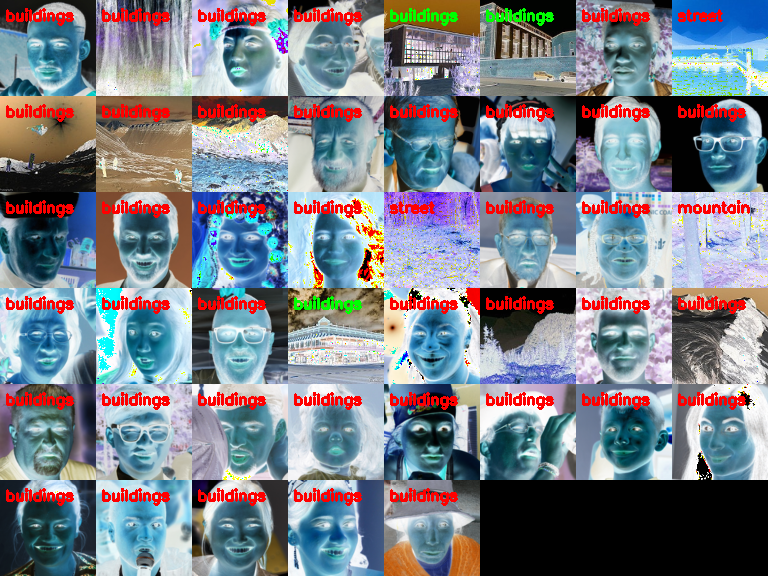

In [494]:
view_prediction(DJSc_model,test_ALLdataJay,testALL_y)

In [ ]:
testY[:20]

In [ ]:
def massPrediction(Jmodel):
  # Jmodel MASS PREDICTION (pending 'test_ALLdataJay' ... DONE)
  from sklearn.metrics import accuracy_score

  #y_pred  = Jmodel.predict(testXprep ).argmax(-1)
  #J_y_pred  = Jmodel.predict(np.array(test_ALLdataJay)).argmax(-1)

  testY=to_categorical(testALL_y)
  testY_revCat=np.argmax(testY,axis=1)

  #SLICE PREDICTION

  #Slice partiton
  print("test_ALLdataJaylength is ...", len(test_ALLdataJay) )

  startPt=int(input('Please provide the slice Start-Point...'))
  print("input startPt is ...", startPt)
  sliceRange=int(input('Please provide the slice range...'))
  print("input sliceRange is ...", sliceRange)


  if startPt + sliceRange<=len(test_ALLdataJay):
    endPt = startPt + sliceRange - 1
    print("slice last index (endPoint) is ...", endPt)

    #Slice Prediction on UnTraine Jmodel
    sliceJ_y_pred  = Jmodel.predict(np.array(test_ALLdataJay[startPt:endPt])).argmax(-1)
    print('sliceJ_y_pred array is ...',sliceJ_y_pred)
    slice_testY_revCat=testY_revCat[startPt:endPt]
    print('slice_testY_revCat array is ...', slice_testY_revCat)

    #print("Test accuracy " , accuracy_score(testY_revCat , y_pred ))
    print("Test accuracy " , accuracy_score(slice_testY_revCat , sliceJ_y_pred ))

  else:
    print('Last index slice Not Available...function closing...sorry!')
  return  slice_testY_revCat , sliceJ_y_pred

In [ ]:
DJSc_model.name

In [ ]:
slice_testY_revCat , sliceJ_y_pred=massPrediction(DJSc_model)

In [ ]:
len(testY_revCat)

In [ ]:
testY_revCat

In [ ]:

def bingoMassPrediction(Jmodel, test_ALLdataJay, testALL_y):

  # testY=to_categorical(test_y)
  #REMINDER #testY_revCat=np.argmax(testY,axis=1)

  # Jmodel MASS PREDICTION (pending 'test_ALLdataJay' ... DONE)
  from sklearn.metrics import accuracy_score

  #y_pred  = Jmodel.predict(testXprep ).argmax(-1)
  #J_y_pred  = Jmodel.predict(np.array(test_ALLdataJay)).argmax(-1)

  testY=to_categorical(testALL_y)
  testY_revCat=np.argmax(testY,axis=1)

  #SLICE PREDICTION

  #Slice partiton
  print("test_ALLdataJaylength is ...", len(test_ALLdataJay) )
  startPt=int(input('Please provide the slice Start-Point...'))
  print("input startPt is ...", startPt)
  sliceRange=int(input('Please provide the slice range...'))
  print("input sliceRange is ...", sliceRange)


  if startPt + sliceRange>len(test_ALLdataJay):
    print('Last index slice Not Available...function closing...sorry!')

  endPt = startPt + sliceRange - 1
  print("slice last index (endPoint) is ...", endPt)

  #Slice Prediction on UnTrained Jmodel
  sliceJ_y_pred  = Jmodel.predict(np.array(test_ALLdataJay[startPt:endPt])).argmax(-1)
  print('sliceJ_y_pred array is ...',sliceJ_y_pred)
  slice_testY_revCat=testY_revCat[startPt:endPt]
  print('slice_testY_revCat array is ...', slice_testY_revCat)

  #print("Test accuracy " , accuracy_score(testY_revCat , y_pred ))
  print("Test accuracy " , accuracy_score(slice_testY_revCat , sliceJ_y_pred ))

In [ ]:
trainXprep, testXprep = prep_pixels(np.array(train_ALLdataJay), np.array(test_ALLdataJay))
 # summarize pixel prepa
print('trainXprep=%s, testXprep=%s' % (trainXprep.shape, testXprep.shape))

testY=to_categorical(testALL_y)
  testY_revCat=np.argmax(testY,axis=1)

  #SLICE PREDICTION

  #Slice partition
  print("test_ALLdataJaylength is ...", len(test_ALLdataJay) )
  startPt=int(input('Please provide the slice Start-Point...'))
  print("input startPt is ...", startPt)
  sliceRange=int(input('Please provide the slice range...'))
  print("input sliceRange is ...", sliceRange)

  if startPt + sliceRange<=len(test_ALLdataJay):
    endPt = startPt + sliceRange - 1
    print("slice last index (endPoint) is ...", endPt)

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

###HERE...2025Apr24th....!!!!

In [ ]:
cv2_imshow(testXprep[6])

REMINDER
```
for roi in rois:
  #prepare the image roi...CRUCIAL...!!!
  prep_roi=prepaReshape(roi)
  # classify the object
  probs = DJSc_model.predict(prep_roi) #array of probabilities for each of the 7 classes
  prediction = probs.argmax(axis=1) # class'index of the highest probability
  #label = labelNames[prediction[0]]
  label=classJay[prediction[0]]  #
  print(f'roi_{i} label is {label}')
  cv2_imshow(roi)
  i+=1
```

In [ ]:
view_prediction(DJSc_model,test_ALLdataJay,testALL_y)

In [ ]:
view_NORMALised_prediction(DJSc_model,testXprep,testALL_y)

In [ ]:

#with DJSc_model

# loop over the image pyramid
# strangely non-persistent pyramid objet as yielded items disappear...to have empty list after few seconds

# initialize the image pyramid
#pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
pyramid4jay = image_pyramid(imgBingo)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image

rois=[]
#rois = list([]) ## list Reinforcement is CRUCIAL to avoid error
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

for img in pyramid4jay:
  count=1 #DJSc_count
  scale=jW / float(img.shape[1])
  for (x, y, roiOrig) in sliding_window(img, WIN_STEP, ROI_SIZE):
    if count>2:
      break
    # scale the (x, y)-coordinates of the ROI with respect to the
    #*original* image dimensions
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    # take the ROI and preprocess it so we can later classify
    # the region using Keras/TensorFlow
    roi = cv2.resize(roiOrig, INPUT_SIZE)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our list of ROIs and associated coordinates
    rois.append(roi)
    #list(rois).append(roi) #DJSc_debug...reinforced rois as list at declaration
    print(f'length list rois is {len(list(rois))}') #DJSc_test
    locs.append((x, y, x + w, y + h))
    print(f'length locs is {len(locs)}') #DJSc_test

  #Handling optional visualisation
    visual=1

    # check to see if we are visualizing each of the sliding
    # windows in the image pyramid
    #if args["visualize"] > 0:
    if visual > 0:
      clone=roiOrig.copy()
      # clone the original image and then draw a bounding box
	    # surrounding the current region
	    #clone = orig.copy()
      cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
      #show the visualization and current ROI
      cv2_imshow(clone)
      cv2_imshow(roiOrig)
      count+=1
      #cv2.waitKey(0) #ERROR
      #error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error)
      #The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support.
      #If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'

    #Above, we visualize both the original image with a green box indicating where we are “looking” and the resized ROI, which is ready for classification (Lines 85-95).
      #As you can see, we’ll only --visualize when the flag is set via the command line.
    if len(rois)==0:
      print(f'rois array is EMPTY as length is {len(rois)}') #DJSc_test
      break

  #Next, we’ll (1) check our benchmark on the pyramid + sliding window process,
    #(2) classify all of our rois in batch, and (3) decode predictions:

  # show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took

print("[INFO] classifying ROIs...")
start = time.time()

preds = DJSc_model.predict(rois)

end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)

#Finally, Line 117 below decodes the predictions, grabbing only the top prediction for each ROI.
#preds = imagenet_utils.decode_predictions(preds, top=1)
np.argmax(DJSc_model.predict(rois), axis=-1)[0] #replacing DJSc_model.predict_classes(rois)

#We’ll need a means to map class labels (keys) to ROI locations associated with that label (values);
#the labels dictionary (Line 118) serves that purpose.

#Let’s go ahead and populate our labels dictionary now:
labels = {}


**def jayMassPrediction REFERENCE**
```
def jayMassPrediction(Jmodel):
  # Jmodel MASS PREDICTION (pending 'test_ALLdataJay' ... DONE)
  from sklearn.metrics import accuracy_score

  #y_pred  = Jmodel.predict(testXprep ).argmax(-1)
  #J_y_pred  = Jmodel.predict(np.array(test_ALLdataJay)).argmax(-1)

  #SLICE PREDICTION

  #Slice partiton
  print("test_ALLdataJaylength is ...", len(test_ALLdataJay) )
  startPt=int(input('Please provide the slice Start-Point...'))
  print("input startPt is ...", startPt)
  sliceRange=int(input('Please provide the slice range...'))
  print("input sliceRange is ...", sliceRange)


  if startPt + sliceRange>len(test_ALLdataJay):    
    print('Last index slice Not Available...function closing...sorry!')

  endPt = startPt + sliceRange - 1
  print("slice last index (endPoint) is ...", endPt)

  #Slice Prediction on UnTraine Jmodel
  sliceJ_y_pred  = Jmodel.predict(np.array(test_ALLdataJay[startPt:endPt])).argmax(-1)
  print('sliceJ_y_pred array is ...',sliceJ_y_pred)
  slice_testY_revCat=testY_revCat[startPt:endPt]
  print('slice_testY_revCat array is ...', slice_testY_revCat)

  #print("Test accuracy " , accuracy_score(testY_revCat , y_pred ))
  print("Test accuracy " , accuracy_score(slice_testY_revCat , sliceJ_y_pred ))


```

REMINDER
```
np.random.choice(imgDIR_path_list)
imgBingo_path=np.random.choice(imgDIR_path_list)
imgBingo_path
OUTPUT_sample >>> ./originalPics/2002/07/20/big/img_656.jpg

pyramid = image_pyramid(imgBingo_rsz, scale=PYR_SCALE, minSize=ROI_SIZE) #

```

In [ ]:
imgList=[cv2.imread(imgPath) for imgPath in imgDIR_path_list]
#np.array(imgList).shape
imgList
len(imgList)

In [ ]:
DJSc_model.input_shape

In [ ]:
def slicePredict(Jmodel):

  testY=to_categorical(testALL_y)
  testY_revCat=np.argmax(testY,axis=1)

  #SLICE PREDICTION

  #Slice partition
  print("test_ALLdataJaylength is ...", len(test_ALLdataJay) )
  startPt=int(input('Please provide the slice Start-Point...'))
  print("input startPt is ...", startPt)
  sliceRange=int(input('Please provide the slice range...'))
  print("input sliceRange is ...", sliceRange)

  if startPt + sliceRange<=len(test_ALLdataJay):
    endPt = startPt + sliceRange - 1
    print("slice last index (endPoint) is ...", endPt)

  #Slice Prediction on UnTrained Jmodel
  sliceJ_y_pred  = Jmodel.predict(np.array(test_ALLdataJay[startPt:endPt])).argmax(-1)
  print('sliceJ_y_pred array is ...',sliceJ_y_pred)
  slice_testY_revCat=testY_revCat[startPt:endPt]
  print('slice_testY_revCat array is ...', slice_testY_revCat)

  #print("Test accuracy " , accuracy_score(testY_revCat , y_pred ))
  print("Test accuracy " , accuracy_score(slice_testY_revCat , sliceJ_y_pred ))

In [ ]:
slice

In [ ]:
#bingoMassPrediction(bbFACE_model,test_ALLdataJay, test_y)USE with INTEL-FFHQ data


```imagenet_utils.decode_prediction```

Decodes the prediction of an ImageNet model.

**Arguments:**

  **preds:**    
  * Numpy array encoding a batch of predictions.
  *top: Integer, how many top-guesses to return. Defaults to 5.

**Returns:**

  A list of lists of top class prediction tuples
(class_name, class_description, score).

**Resumption**

In [ ]:
# loop over the image pyramid2iB
for image in pyramid4jay:
  #looping start above...	# determine the scale factor between the *original* image
  # dimensions and the *current* layer of the pyramid2iB
  scale = jW / float(image.shape[1])
  # for each layer of the image pyramid2iB, loop over the sliding
  # window locations

  for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
    # scale the (x, y)-coordinates of the ROI with respect to the
    # *original* image dimensions
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    # take the ROI and preprocess it so we can later classify
    # the region using Keras/TensorFlow roi = cv2.resize(roiOrig, INPUT_SIZE)
    roi = cv2.resize(roiOrig, INPUT_SIZE)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    #update our list of ROIs and associated coordinates
    rois.append(roi)
    locs.append((x, y, x + w, y + h))
    visual=1
    # check to see if we are visualizing each of the sliding
    # windows in the image pyramid2iB
    #if args["visualize"] > 0:
    if visual > 0:
      # clone the original image and then draw a bounding box
      # surrounding the current region
      clone = orig.copy()
      #clone = imgBingo_rsz.copy()
      cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

      #show the visualization and current ROI
      cv2_imshow(clone)
      cv2_imshow(roiOrig)
      cv2.waitKey(0)


    # show how long it took to loop over the image pyramid2iB layers and
  # sliding window locations
  end = time.time()
  print("[INFO] looping over pyramid2iB/windows took {:.5f} seconds".format(
	end - start))
  # convert the ROIs to a NumPy array
  rois = np.array(rois, dtype="float32")

  # classify each of the proposal ROIs using ResNet and then show how
  # long the classifications took
  print("[INFO] classifying ROIs...")
  start = time.time()

  preds = model.predict(rois)

  end = time.time()
  print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))
  # decode the predictions and initialize a dictionary which maps class
  # labels (keys) to any ROIs associated with that label (values)

  #FIX


  #One list of tuples per sample in batch input.

  preds = imagenet_utils.decode_predictions(preds, top=1)
  labels = {}

  # loop over the predictions
  #L121 next line...
  for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

	  # filter out weak detections by ensuring the predicted probability
	  # is greater than the minimum probability
    if prob >= args["min_conf"]:
		  # grab the bounding box associated with the prediction and
		  # convert the coordinates
      box = locs[i]
      # grab the list of predictions for the label and add the
		  # bounding box and probability to the list
      L = labels.get(label, [])
      L.append((box, prob))
      labels[label] = L

      # loop over the labels for each of detected objects in the image #L139
    for label in labels.keys():
	    # clone the original image so that we can draw on it
      print("[INFO] showing results for '{}'".format(label))
      clone = orig.copy()

      # loop over all bounding boxes for the current label
      for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
	    # show the results *before* applying non-maxima suppression, then
      # clone the image again so we can display the results *after*
      # applying non-maxima suppression
      cv2.imshow("Before", clone)
      clone = orig.copy()

      # extract the bounding boxes and associated prediction
	    # probabilities, then apply non-maxima suppression
      boxes = np.array([p[0] for p in labels[label]])
      proba = np.array([p[1] for p in labels[label]])
      boxes = non_max_suppression(boxes, proba)
      # loop over all bounding boxes that were kept after applying
	    # non-maxima suppression
      for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
			    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	    # show the output after apply non-maxima suppression
      cv2.imshow("After", clone)
      cv2.waitKey(0)




First, we end our pyramid + sliding window timer and show how long the process took (Lines 99-101).

Then, we take the ROIs and pass them (in batch) through our pre-trained image classifier (i.e., ResNet) via predict (Lines 104-118). As you can see, we print out a benchmark for the inference process here too.

Finally, Line 117 decodes the predictions, grabbing only the top prediction for each ROI.

We’ll need a means to map class labels (keys) to ROI locations associated with that label (values); the labels dictionary (Line 118) serves that purpose.

Let’s go ahead and populate our labels dictionary now:

```
# loop over the predictions
#L121 next line...
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
  # L127 next...
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]
		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L


```

In [ ]:
#REASSESS...
visual=0
# check to see if we are visualizing each of the sliding
# windows in the image pyramid2iB
#if args["visualize"] > 0:
if visual > 0:

	# clone the original image and then draw a bounding box
	# surrounding the current region
  for (x, y, roiOrig) in sliding_window(imgBingo, WIN_STEP, ROI_SIZE):
    # scale the (x, y)-coordinates of the ROI with respect to the
    # *original* image dimensions
    x = int(x * scale)
    y = int(y * scale)
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)

	  #clone = orig.copy()
    clone = imgBingo_rsz.copy()
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

    #show the visualization and current ROI
    cv2_imshow(clone)
    cv2_imshow(roiOrig)
    cv2.waitKey(0)



In [ ]:
from google.colab import files
files.upload()

In [ ]:
pwd

In [ ]:
ls

In [ ]:
#!python detect_with_classifier.py --image images/stingray.jpg --size "(300, 150)"


Output
```
[INFO] loading network...
[INFO] looping over pyramid/windows took 0.19142 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 9.67027 seconds
[INFO] showing results for 'stingray'
```

https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

**for Py file**
```
# import the necessary packages
import imutils

def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

```

```
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

```

```
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid
import numpy as np
import argparse
import imutils
import time
import cv2

```

```
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
	help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.9,
	help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=-1,
	help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args())


```

```
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

```
```
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

```
```
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

```
```
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

```
```
# check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if args["visualize"] > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)
			# show the visualization and current ROI
			cv2.imshow("Visualization", clone)
			cv2.imshow("ROI", roiOrig)
			cv2.waitKey(0)

```
```
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

```
```
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]
		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

```

```
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	cv2.imshow("Before", clone)
	clone = orig.copy()

```

```
	# extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)
	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	# show the output after apply non-maxima suppression
	cv2.imshow("After", clone)
	cv2.waitKey(0)

```

```



```


Apply path (2025Apr19th_review)
https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/

`
df = df.assign(Product=lambda x: (x['Field_1'] * x['Field_2'] * x['Field_3']))
`
```
# Apply function numpy.square() to square
# the values of one row only i.e. row
# with index name 'd'
df = df.apply(lambda x: np.square(x) if x.name == 'd' else x, axis=1)
```

In [ ]:
#TRIAL
# importing pandas and numpy libraries
import pandas as pd
import numpy as np

# creating and initializing a nested list
values_list = [[15, 2.5, 100], [20, 4.5, 50], [25, 5.2, 80],
               [45, 5.8, 48], [40, 6.3, 70], [41, 6.4, 90],
               [51, 2.3, 111]]

# creating a pandas dataframe
df = pd.DataFrame(values_list, columns=['Field_1', 'Field_2', 'Field_3'],
                  index=['a', 'b', 'c', 'd', 'e', 'f', 'g'])


# Apply function numpy.square() to square
# the values of one row only i.e. row
# with index name 'd'
df = df.apply(lambda x: np.square(x) if x.name == 'd' else x, axis=1)


# printing dataframe
#df